# Heart Attack Analysis & Prediction Project

The purpose of this project is to analyze existing features of patients provided by the input dataset, and determine which features have the most impact on whether a person gets a heart attack or not. The input dataset has a target column which is a value either 0 or 1 indicating whether a patient got a heart attack (1) or not (0). I will attempt to build a classification model that can accurately predict whether a patient will get a heart attack or not and then use model explainability libraries to understand which features have the most impact on a heart attack.

## 1. Import the data into the notebook

In [3]:
import os
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import math
warnings.filterwarnings("ignore")

# This function will take in a file path and a filename and then attempt to load the file in
def load_data(file_path , filename):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path)

In [4]:
# This function will be used to write output files to act as checkpoints in the project
def write_csv_data(file_path, filename, df):
    isExist = os.path.exists(file_path)
    if not isExist:
        os.makedirs(file_path)
        print("The new directory is created!")
    csv_path = os.path.join(file_path, filename)
    df.to_csv(csv_path)
    
    if os.path.exists(csv_path) and os.path.getsize(csv_path) > 0:
        print(filename + " was written to successfully!")

In [5]:
input_file_path = "Input/"

df_heart_data = load_data(input_file_path, "heart.csv")

## 2. Take a quick look at the imported dataframe
We will use several functions to get a feel for the data such as head, info, and describe.

In [6]:
df_heart_data.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [7]:
df_heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


The info function will give us details on whether any fields contains null values, type mismatches, or missing values. **Based on the results above it is safe to say that there is no null values, no type mismatches, and no missing values. Therefore we will not need a section to handle null values or convert types.**

In [8]:
df_heart_data.describe()

age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

## 3. Rename columns to be more descriptive
I find the columns are very obscure and it will make more sense to rename the columns so it is easy to use later on.

In [9]:
def rename_columns_heart_data(df):
    df = df.rename(columns={"cp":"chest_pain_type", "trtbps":"resting_blood_pressure", "chol":"cholesterol", "fbs": "fasting_blood_sugar", "restecg": "resting_electrocardiographic_results"})
    df = df.rename(columns={"thalachh": "maximum_heart_rate", "exng": "exercise_induced_angina", "oldpeak":"old_peak", "slp":"slope", "caa":"num_major_vessels", "thall":"thal_rate", "output":"heart_attack_target"})
    
    return df

In [10]:
df_heart_data = rename_columns_heart_data(df_heart_data)

In [11]:
df_heart_data.head()

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   

   fasting_blood_sugar  resting_electrocardiographic_results  \
0                    1                                     0   
1                    0                                     1   
2                    0                                     0   
3                    0                                     1   
4                    0                                     1   

   maximum_heart_rate  exercise_induced_angina  old_peak  slope  \
0                 150                        0       2.3      0   
1                 187                        0       3.5      0   
2                 172                        0       1.4      2   
3                 178                        0       0.8      2   
4                 163                        1       0.6      2   

   num_major_vessels  thal_rate  heart_attack_target  
0                  0          1                    1  
1                  0          2                    1  
2                  0          2                    1  
3                  0          2                    1  
4                  0          2                    1

In [12]:
# Writing out the renamed dataframe to file
write_csv_data("Outputs", "heart_data_renamed.csv", df_heart_data)

The new directory is created!
heart_data_renamed.csv was written to successfully!


Now that we have renamed the necessary columns and written the dataframe out to file, we will perform the train test split before analyzing the data. The reason for this is to prevent any human bias by observing and analyzing the test data.

In [10]:
train_set, test_set = train_test_split(df_heart_data, test_size=0.2, random_state=42)

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 132 to 102
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   242 non-null    int64  
 1   sex                                   242 non-null    int64  
 2   chest_pain_type                       242 non-null    int64  
 3   resting_blood_pressure                242 non-null    int64  
 4   cholesterol                           242 non-null    int64  
 5   fasting_blood_sugar                   242 non-null    int64  
 6   resting_electrocardiographic_results  242 non-null    int64  
 7   maximum_heart_rate                    242 non-null    int64  
 8   exercise_induced_angina               242 non-null    int64  
 9   old_peak                              242 non-null    float64
 10  slope                                 242 non-null    int64  
 11  num_major_vessels

As we can see above, the training data has 242 entries while the test set will naturally have 61.

## 4. Univariate Analysis

Univariate Analysis is used to analyze a single feature to understand its variance and central tendencies in order to determine if it will or will not be a good feature for forecasting the target variable.

## 4a. Generating histograms to analyze distribution of each feature

In [12]:
# Copying the training set so we do not modify the actual training set
train_copy = train_set.copy()

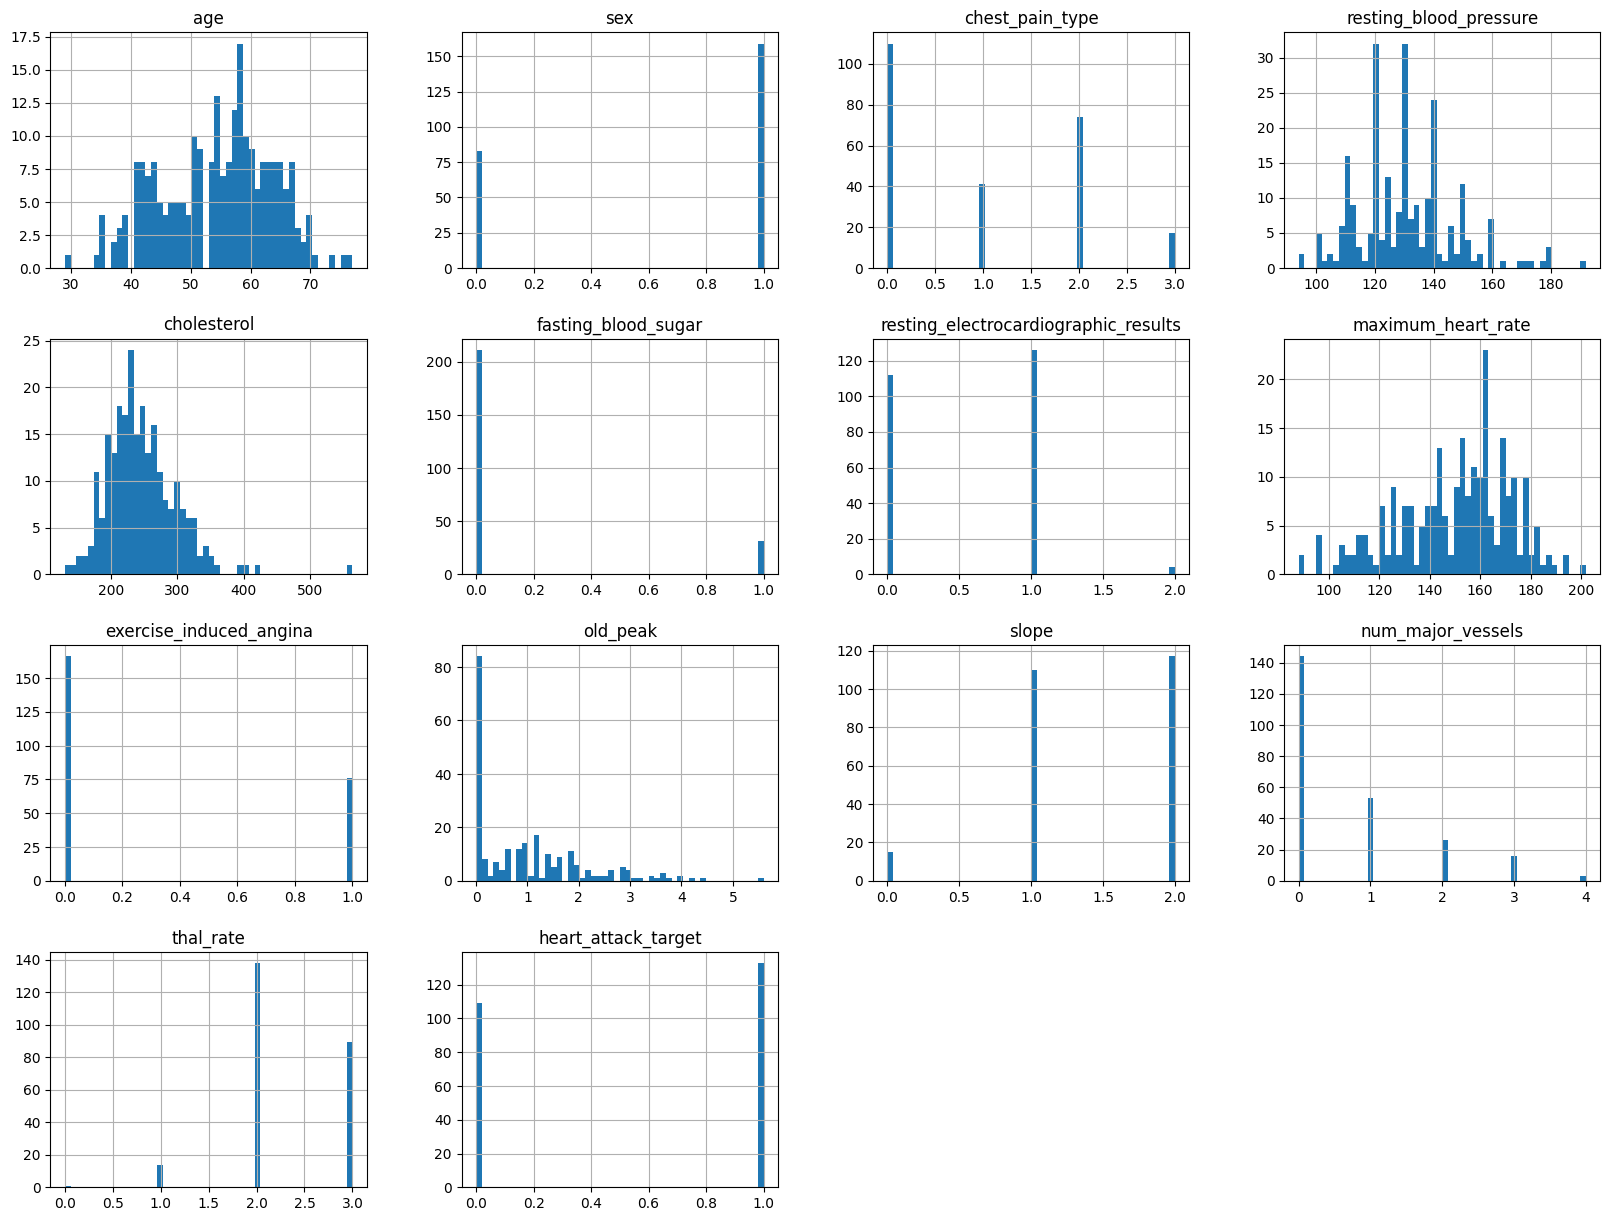

In [13]:
%matplotlib inline
train_copy.hist(bins=50, figsize=(20,15))
plt.show()

### Histogram Observations
So the histogram above indicates that: 

1. Majority of the patients' age ranges from 40 to about 65. There is fairly little data for patients younger than 40 and older than 67 which is a key consideration when analyzing the results of this model.

2. Sex is used to indicate the gender of the patient. The possible values are Male (1) or Female (0).

3. Fasting blood sugar is a binary class on whether the patient's blood sugar level exceeds 120 mg/dl and it can be yes (1) or no (0).

4. Exercise induced angina indicates whether a patient suffered from chest pain after exercise. The values can be either yes (1) or no (0). 

5. Heart attack target is whether a patient got a heart attack or not. Possible values can be yes (1) or no (0). **Target metric**

6. Chest Pain type has 4 classes and they are as follows: asymptomatic (0), typical angina (1), atypical angina (2), non-anginal pain (3).

7. Resting blood pressure seems to fall within the range of 110 and 150. These values seem to indicate the Systolic blood pressure, the pressure the heart exerts while beating, of the patient with their higher range. A normal Systolic blood pressure would be 129 and less so any of the values above it would indicates different stages of hyperextension.

8. The cholestrol level of patients mostly fall between 170 and 300 based on the histogram above. Based on research, a cholestrol level of 200 or less is considered normal, 200-240 is considered borderline high, and anything above is very high.

9. The 3 possible values for the resting electrocardiographic results include: Normal (0), ST-T wave abnormality(1) (irregular heartbeat usually benign), probably or definite left ventricular hypertrophy(2) (thickening of the left ventricle septum)  making it harder for blood to be pumped to the entire body hence increased blood pressure.

10. The maximum heart rate seems to fall between 140 and 180. The easiest way to calculate your maximum heart rate is to subtract your age from 220. 

11. Old peak seems to be related to ST depression while exercising relative to rest which is related to exercise induced angina; however, this is the result in an EKG test. Values represent the measurement of the depression.

12. Slope is related to ST segment health relative to exercise induced increments in heart rate. The values are as follows with Upsloping (1), Flat (2), or Downsloping (3).

13. Number of major vessels indicates the number of major vessels affected in a heart attack and the values range from 0 to 3. 

14. Thal is a blood disorder known as thalessemia and it causes a person to have less hemoglobin than normal which can lead to the person feeling more fatigued and anemic. The values mean as follows: 3 -> normal, 6 -> fixed defect, 7 -> reversable defect.

## 4b. Univariate analysis of cholesterol levels

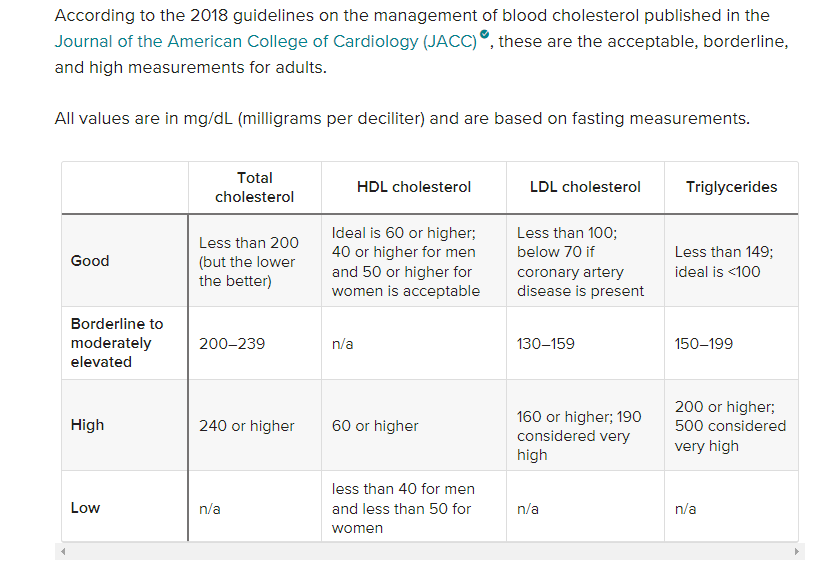

Based on table above, a healthy cholesterol for adults (which most of the data is representative of) would be less than 200, 200-239 would be considered borderline ok, and 240 or higher is high risk. Knowing this, let's take a look at the distribution of the cholesterol data. Data was captured from this [source](https://www.healthline.com/health/high-cholesterol/levels-by-age#adults).

In [14]:
train_copy['cholesterol'].quantile([0.25, 0.5,0.75])

0.25    212.00
0.50    239.50
0.75    274.75
Name: cholesterol, dtype: float64

The code above returns the effective range of cholesterol data. What this says is that 25% of the data points are found here when all values are arranged in increasing order. The effective range for cholesterol values that fits into the data's distribution would be between 212 (25%) and 274.75 (75%). What this tells us is that the typical cholesterol levels for patients in the training data fall between borderline ok and high risk based on the table above.

This is important to know since we are inherently dealing with troublesome cholesterol levels for majority of the data. Since all of the cholesterol levels are fairly bad then this should not be the most accurate feature to determine whether someone gets a heart attack or not. Time to further analyze the distribution of the data.

<AxesSubplot: xlabel='cholesterol', ylabel='Count'>

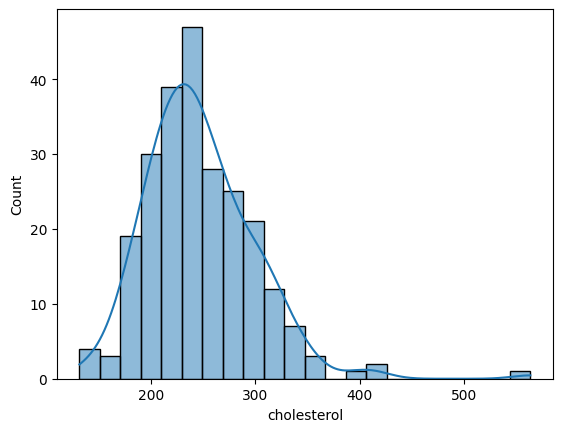

In [15]:
sns.histplot(train_copy['cholesterol'], kde=True)

The data seems to be a normal distribution that has been skewed by quite a few large outliers. To get a better idea of how far off the outliers are, we can see a box plot below.

<AxesSubplot: >

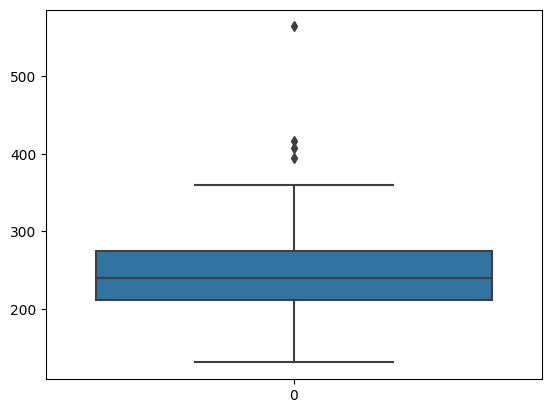

In [16]:
sns.boxplot(train_copy['cholesterol'])

What this tells us is that there are clearly some large outliers skewing the data. Will check how many outlier cholesterol values exist in the data below.

In [17]:
train_copy[(train_copy['cholesterol'] > 274.75) | (train_copy['cholesterol'] < 212)]

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
132   42    1                1                     120          295   
59    57    0                0                     128          303   
93    54    0                1                     132          288   
6     56    0                1                     140          294   
177   64    1                2                     140          335   
..   ...  ...              ...                     ...          ...   
149   42    1                2                     130          180   
130   54    0                2                     160          201   
151   71    0                0                     112          149   
87    46    1                1                     101          197   
102   63    0                1                     140          195   

     fasting_blood_sugar  resting_electrocardiographic_results  \
132                    0                                     1   
59                     0                                     0   
93                     1                                     0   
6                      0                                     0   
177                    0                                     1   
..                   ...                                   ...   
149                    0                                     1   
130                    0                                     1   
151                    0                                     1   
87                     1                                     1   
102                    0                                     1   

     maximum_heart_rate  exercise_induced_angina  old_peak  slope  \
132                 162                        0       0.0      2   
59                  159                        0       0.0      2   
93                  159                        1       0.0      2   
6                   153                        0       1.3      1   
177                 158                        0       0.0      2   
..                  ...                      ...       ...    ...   
149                 150                        0       0.0      2   
130                 163                        0       0.0      2   
151                 125                        0       1.6      1   
87                  156                        0       0.0      2   
102                 179                        0       0.0      2   

     num_major_vessels  thal_rate  heart_attack_target  
132                  0          2                    1  
59                   1          2                    1  
93                   1          2                    1  
6                    0          2                    1  
177                  0          2                    0  
..                 ...        ...                  ...  
149                  0          2                    1  
130                  1          2                    1  
151                  0          2                    1  
87                   0          3                    1  
102                  2          2                    1  

[121 rows x 14 columns]

This shows us that 121 entries would be considered outliers which is not good since this makes up 39% of the data. The key to note here is that any value just below Q1 and just above Q3 would not be considered extreme outliers since this adds natural variance to the data. 

What we are targeting is the data that are way above or below these fences since they would be responsible for the excessive right tail of the distribution graph above.  Will try temporarily removing the large outliers and seeing if that fixes the data skew issues.

In [18]:
# Utility function that will flag any values that are at least 3 standard deviations away from the mean indicating them to be extreme outliers
def fix_data_skew(df, column_name):
    data_mean = np.mean(df[column_name])
    data_std = np.std(df[column_name])
    
    lower_bound = data_mean - (data_std * 3)
    upper_bound = data_mean + (data_std * 3)
    print(lower_bound)
    print(upper_bound)
    outliers = []
    for val in df[column_name]:
        if val < lower_bound or val > upper_bound:
            outliers.append(val)
            
    return outliers

In [19]:
cholesterol_outliers = fix_data_skew(train_copy, 'cholesterol')
print(cholesterol_outliers)

88.7841633475959
404.9017870656273
[564, 417, 407]


As we can see above, there are only 3 true outlier situations that are well above the Q3 mark. If we were to temporarily remove them, will this remove the excessive tail of the distribution graph?

In [20]:
fixed_cholesterol_skew = train_copy[(train_copy['cholesterol'] < 404) & (train_copy['cholesterol'] > 88)]

<AxesSubplot: xlabel='cholesterol', ylabel='Count'>

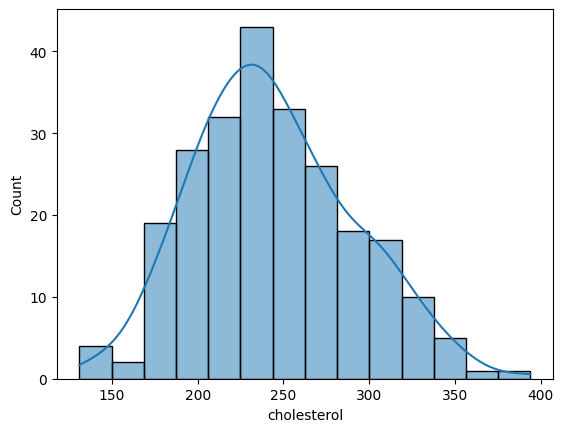

In [21]:
sns.histplot(fixed_cholesterol_skew['cholesterol'], kde=True)

In [22]:
fixed_cholesterol_skew['cholesterol'].quantile([0.25, 0.5,0.75])

0.25    211.5
0.50    239.0
0.75    274.0
Name: cholesterol, dtype: float64

As we can see above, this did fix the issue and now we have a distribution closer to a normal one. Also the quantiles have not be altered so we can effectively remove these 3 rows since they are negatively impacting the data.

In [23]:
train_copy = train_copy[train_copy['cholesterol'] < 404]

In [24]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 132 to 102
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   239 non-null    int64  
 1   sex                                   239 non-null    int64  
 2   chest_pain_type                       239 non-null    int64  
 3   resting_blood_pressure                239 non-null    int64  
 4   cholesterol                           239 non-null    int64  
 5   fasting_blood_sugar                   239 non-null    int64  
 6   resting_electrocardiographic_results  239 non-null    int64  
 7   maximum_heart_rate                    239 non-null    int64  
 8   exercise_induced_angina               239 non-null    int64  
 9   old_peak                              239 non-null    float64
 10  slope                                 239 non-null    int64  
 11  num_major_vessels

We have successfully removed the 3 large cholesterol outliers! Will continue the distribution analysis of maximum heart rate and resting blood pressure below.

## 4c. Univariate analysis of resting blood pressure

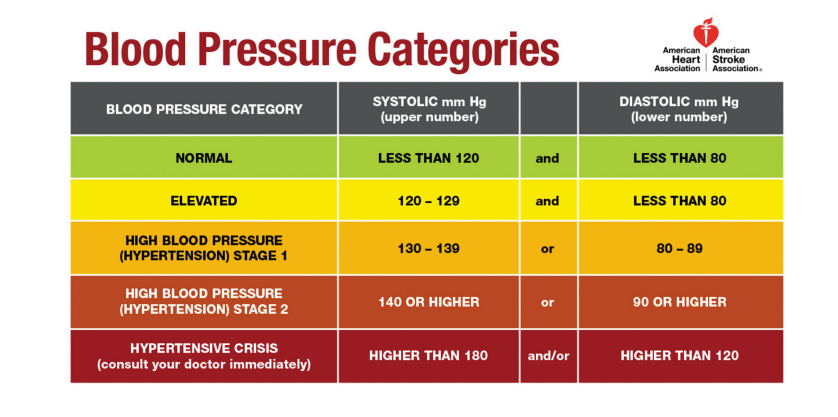

According the table above, an ideal systolic blood pressure would be less than 120, between 120 and 140 would be considered moderate, and above 140 would be bad. Knowing this, we will analyze the quantiles of the data's resting blood pressure now. This data was captured from this [link.](https://www.health.harvard.edu/heart-health/reading-the-new-blood-pressure-guidelines)

In [25]:
train_copy['resting_blood_pressure'].quantile([0.25, 0.5, 0.75])

0.25    120.0
0.50    130.0
0.75    140.0
Name: resting_blood_pressure, dtype: float64

The code above returns the effective range of resting blood pressure data. As we can see above, most of the data lies within the 120-140 range which correlates with the table above. Since the resting blood pressure seems to be evenly balanced between good, moderate, and bad then this would be helpful in determining which patient had a heart attack as oppose to the cholesterol data.

The reason why I say this is because it seems to include fairly good resting blood pressure levels as oppose to the cholesterol data that ranged from moderate to high risk mostly.

<AxesSubplot: xlabel='resting_blood_pressure', ylabel='Count'>

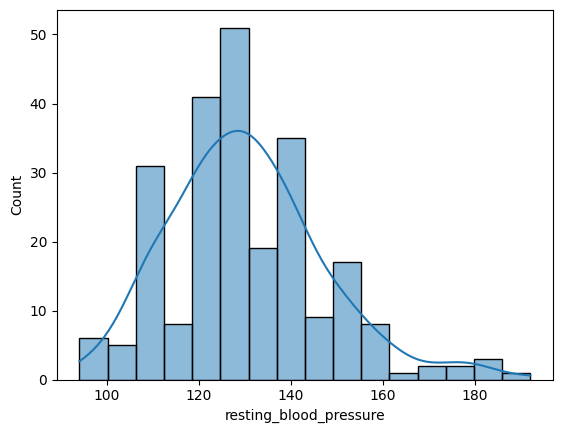

In [26]:
sns.histplot(train_copy['resting_blood_pressure'], kde=True)

The distribution above seems to be a normal one with a longer tail than expected. We will do a similiar procedure above with the cholesterol data to remove any excessive data skews. First we will use a box plot to visualize outliers.

<AxesSubplot: >

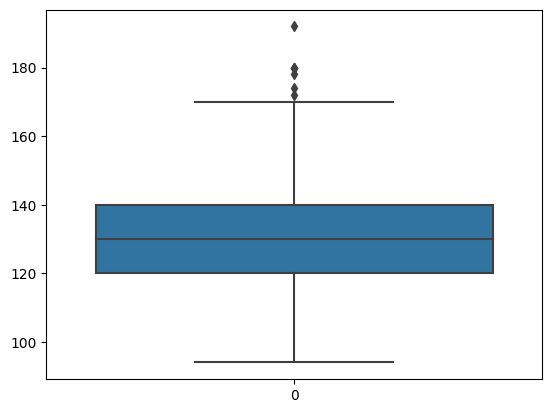

In [27]:
sns.boxplot(train_copy['resting_blood_pressure'])

There definitely seems to be quite a few large outliers according to the box plot above, however not all outliers would be bad for the data. Outliers inherently add variance to the data, however extreme outliers add too much variance which can affect our ML model's training.

Similiar to the cholesterol data, I will call the previously built data_skew function to identify any excessive outliers.

In [28]:
resting_blood_pressure_outliers = fix_data_skew(train_copy, 'resting_blood_pressure')
print(resting_blood_pressure_outliers)

79.87027639779528
180.73223406245575
[192]


There seems to be only 1 very large value which is more than 3 standard deviations away from our mean. We can opt to keep this row or remove it. I will opt to remove it for now.

In [29]:
train_copy = train_copy[train_copy['resting_blood_pressure'] < 190]

In [30]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238 entries, 132 to 102
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   238 non-null    int64  
 1   sex                                   238 non-null    int64  
 2   chest_pain_type                       238 non-null    int64  
 3   resting_blood_pressure                238 non-null    int64  
 4   cholesterol                           238 non-null    int64  
 5   fasting_blood_sugar                   238 non-null    int64  
 6   resting_electrocardiographic_results  238 non-null    int64  
 7   maximum_heart_rate                    238 non-null    int64  
 8   exercise_induced_angina               238 non-null    int64  
 9   old_peak                              238 non-null    float64
 10  slope                                 238 non-null    int64  
 11  num_major_vessels

In [31]:
train_copy['resting_blood_pressure'].quantile([0.25, 0.5, 0.75])

0.25    120.0
0.50    130.0
0.75    140.0
Name: resting_blood_pressure, dtype: float64

<AxesSubplot: xlabel='resting_blood_pressure', ylabel='Count'>

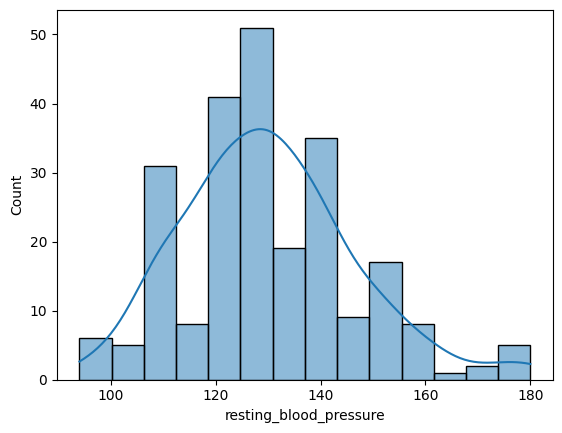

In [32]:
sns.histplot(train_copy['resting_blood_pressure'], kde=True)

As we can see from the quantiles and the histogram plot above, the quantiles have not been altered while the histogram plot has changed slightly. The ending tail is a bit shorter. Now that we know resting blood pressure is good and is a potential feature to predict heart attack chances, then we can continue to another feature.

## 4d. Univariate analysis of maximum heart rate

Analysis for maximum heart rate will be unique compared to cholesterol level and resting blood pressure since maximum heart rate is heavily dependent on age. Cholesterol level and resting blood pressure are also reliant on age, however age is critical for calculating a healthy and unhealthy maximum heart rate for a person.

According to Centers for Disease Control and Prevention website, "you can estimate your maximum heart rate based on your age. To estimate your maximum age-related heart rate, subtract your age from 220. For example, for a 50-year-old person, the estimated maximum age-related heart rate would be calculated as 220 – 50 years = 170 beats per minute (bpm)." This was captured from this [link.](https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm#:~:text=You%20can%20estimate%20your%20maximum,beats%20per%20minute%20(bpm).)

The way to analyze this is to simply compute the ideal maximum heart rate for each patient based on their age and then check if their maximum heart rate exceeds it. If it does then the patient will be flagged as being at risk.

In [33]:
maximum_heart_rate_risks = train_copy[train_copy['maximum_heart_rate'] > (220 - train_copy['age'])]

The line above will perform the computation mentioned above to estimate the age related maximum heart rate. We then extracted all patients that had a maximum heart rate that exceeded their age's limit.

In [34]:
maximum_heart_rate_risks['maximum_heart_rate'].quantile([0.25, 0.5, 0.75])

0.25    165.0
0.50    172.0
0.75    179.0
Name: maximum_heart_rate, dtype: float64

As we can see above, the range of high risk maximum heart rates vary from 165 to 179 which indicates that these patients are older but have a maximum heart rate exceeding their age's limit.

<AxesSubplot: xlabel='maximum_heart_rate', ylabel='Count'>

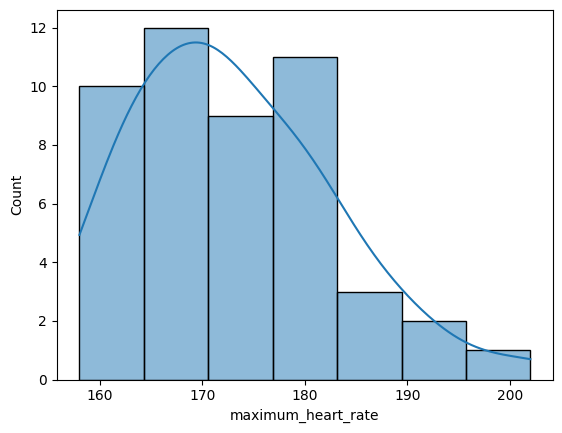

In [35]:
sns.histplot(maximum_heart_rate_risks['maximum_heart_rate'], kde=True)

As the data shows above, it is a normal distribution that is not evenly balanced on the left side. Based on the data for maximum heart rate, this might be a feature that will help the model to predict heart attack chances for patients. Will do further analysis below to better understand if this feature along with others will have an impact on heart attack chances.

# 5. Bivariate Analysis

Bivariate Analysis is analysis comparing 2 features to one another to understand relationships that may be present between them.

Will generate a set of bar charts to analyze the distribution of the various binary and multi class features present.

## 5a. Analyzing relationship between sex and heart attack results
Will start by analyzing the distribution of heart attack results for each sex.

In [36]:
train_copy['named_sex'] = None
train_copy.loc[train_copy['sex'] == 1, 'named_sex'] = 'Male'
train_copy.loc[train_copy['sex'] == 0, 'named_sex'] = 'Female'
px.histogram(train_copy, x='heart_attack_target', color='named_sex', hover_data=train_copy.columns, title="Distribution of Sex and Heart Attack Results", barmode="group", color_discrete_map={"Male": "Skyblue", "Female": "Purple"})

It is clear from the histogram above that there is more male patients in the dataset. The good thing is that the number of positive heart attack patients are evenly distributed between Male and Female however, the same cannot be said for the negative heart attack results.

Next I want to analyze the relationship between age and heart attack results.

## 5b. Analyzing relationship between age and heart attack results

In [37]:
px.histogram(train_copy, x='age', color='heart_attack_target', hover_data=train_copy.columns, title="Distribution of Age and Heart Attack Results", barmode="group", color_discrete_map={1: "Red", 0: "Green"})

The histogram above indicates that the majority of the positive heart attack patients were aged between 40 and 59. This is quite insightful since according to an article published in Michigan Health [here](https://healthblog.uofmhealth.org/heart-health/12-heart-attack-risk-factors-you-cant-ignore-infographic), "Majority of heart attack deaths occur in patients ages 65 and older, but a man's risk begins to increase at 45 and for women it starts at 55."

The above charts give us a better picture of the distribution of sex and age respectively in the data. To get an idea for the distribution of the other features relative to heart attack rate can be seen with box plots. We will use this to identify the main quantiles in which a patient may fall in to get a heightened chance of a heart attack. This plot will also point out outliers from the quantiles. 

The first box plot we will use is to analyze the relationship between cholesterol and heart attack results.

## 5c. Analyzing relationship between cholesterol levels and heart attack results

In [38]:
px.box(train_copy, y="cholesterol", x="heart_attack_target", color='heart_attack_target', notched=True, points='all', title="Distrubution of Cholesterol levels and Heart Attack Results")

The box plot indicates that the distribution for heart attacks in patients with a cholesterol between 209 and 282 can be both negative and positive for heart attacks. What this tells us is that cholesterol by itself is not a good indicator for heart attacks in a person. 

This aligns with our early univariate analysis of cholesterol levels since all of the data fell in the range of moderate to high cholesterol levels for the entire dataset. What this tells us is that there isn't enough variance in this feature to help us determine whether a good cholesterol level will lower heart attack chances.

Now I want to analyze the relationship between maximum heart rate and heart attack results.

## 5d. Analyzing relationship between maximum heart rate and heart attack results

In [39]:
px.box(train_copy, y="maximum_heart_rate", x="heart_attack_target", color='heart_attack_target', notched=True, points='all', title="Distrubution of Maximum Heart Rate and Heart Attack Results")

This box plot gives us some important information. What this plot tells us is that a person with a maximum heart rate between 148 and 172 have a higher chance of a heart attack than a person with a maximum heart rate between 125 and 158.

The final relationship I want to analyze is between resting blood pressure and heart attack results.

## 5e. Analyzing relationship between resting blood pressure and heart attack results

In [40]:
px.box(train_copy, y="resting_blood_pressure", x="heart_attack_target", color='heart_attack_target', notched=True, points='all', title="Distrubution of Resting Blood Pressure and Heart Attack Results")

This box plot is very similiar to the cholesterol box plot since it tells us that resting blood pressure by itself is not a strong indicator of whether a person will get a heart attack or not. Next I want to compare chest pain types and heart attack values to determine if there is a relationship.

## 5f. Analyzing relationship between chest pain types and heart attack results

In [41]:
px.histogram(train_copy, x='chest_pain_type', color='heart_attack_target', hover_data=train_copy.columns, title="Distribution of Chest Pain Types and Heart Attack Results", barmode="group", color_discrete_map={1: "Purple", 0: "Navy"})

There clearly seems to be a relationship here since any chest pain type of 1 and higher has a higher chance of a heart attack. 0 indicates asymptomatic which simply means having a condition but showing no symptoms. The other 3 categories are typical angina, non-typical angina, and non-anginal pain respectively and they all have higher number of patients with heart attacks than they have negative results.

# 6. Multivariate Analysis

This analysis uses more than 2 features and compares them all to understand any latent relationships that may be present.

## 6a. Analyzing the relationship between maximum heart rate, resting blood pressure, age, and heart attack target

I first want to see the relationship between resting blood pressure levels, maximum heart rate, age, and heart attack target. What I would like to see is if a higher resting blood pressure, a high maximum heart rate, or being very old will have a higher chance of getting a heart attack. My hypothesis is that at least 1 of these factors being excessively high will mean a chance of a heart attack.

The X axis is resting blood pressure, Y axis is age, the size of the circles is maximum heart rate and the color of the circle is whether a patient got a heart attack (red/pink) or not(blue/green).

In [42]:
px.scatter(train_copy, x='resting_blood_pressure', y='age', size='maximum_heart_rate', color='heart_attack_target', size_max=45, color_continuous_scale='temps', title="Visualizing resting blood pressure and age's impact on heart attack occurrences")

The scatter plot above indicates that there is no direct correlation between resting blood pressure and heart attack chances. As the plot shows above, people with "healthy" blood pressures of under 120 still got heart attacks while people with a blood pressure above 180 did not get a heart attack. 

Also there doesn't seem to be a relationship between age and resting blood pressure levels directly since there doesn't seem to be a consistent pattern of heart attacks, when it comes to these 2 factors in tandem. 

A relationship that is noticeable is the relationship between a high maximum heart rate and a heart attack which makes logical sense since an elevated heart rate indicates the heart has to work harder to pump blood throughout the body. What is important to distinguish is the heart rates are very high for heart attacks. This can be noticed by the larger pink circles compared to the smaller green circles. Size is the attribute tracking maximum heart rate.

## 6b. Analyzing the relationship between cholesterol levels, chest pain type, age, and heart attack target

Next I would like to do a similiar plot as the one above but with age and cholesterol levels and whether a higher cholesterol level will mean a higher heart attack rate. Also will analyze whether different chest pain types have a higher chance of leading to a heart attack.

The X axis is the cholesterol level, Y axis is the age, size of the circle is the chest pain type, and the color of the circle indicates whether the patient got a heart attack (red/brown) or not (dark green/olive).

In [43]:
px.scatter(train_copy, x='cholesterol', y='age', color='heart_attack_target', size='chest_pain_type', color_continuous_scale='fall', size_max=40, title="Visualizing cholesterol level and age's impact on heart attack occurrences", color_discrete_sequence=['green', 'blue'])

There seems to be a bit more information here than the chart above. It seems that individuals younger than 60 with a cholesterol level between 175 and 350 have a heightened chance to get a heart attack. There are a number of non heart attack individuals in this range however from face value it seems like the number of heart attack patients outnumber the ones that didn't get one. Interestingly enough, individuals older than 60 seem to get less heart attacks based on cholesterol level. This may be a misjudgement since this is just from eyeballing this plot.

Another interesting observation is that a higher chest pain type score of 2 and above typically leads to a heart attack.

## 6c. Correlation Matrix Heatmap
Will perform a correlation matrix on the dataset to see the correlation of all features relative to the heart attack target.

In [44]:
px.imshow(train_copy.corr(), title="Correlation Matrix of Heart Data", width=800, height=700)

From the correlation matrix heatmap results above, it seems that the chest_pain_type, maximum_heart_rate, and slope are somewhat correlated to the heart_attack result. Their percentages are not encouraging however they are the best results so far.

The correlation between maximum heart rate and chest pain type was identified in the analysis above so that is definitely encouraging.

Also noteworthy is the thal_rate, num_major_vessels, exercise_induced_angina, and old_peak are somewhat negatively correlated to the heart_attack_rate which is interesting.

# 7. Building utility functions to handle plots and and segmenting the datasets

In [45]:
# This is used to capture all features except for the target label
x_train = train_set.loc[:, train_set.columns != 'heart_attack_target'].copy()
# This is used to extract the target column from the training data and store it as the y labels
y_train = train_set.loc[:, 'heart_attack_target'].copy()

# This does the same as above for the test data
x_test = test_set.loc[:, test_set.columns != 'heart_attack_target'].copy()
y_test = test_set.loc[:, 'heart_attack_target'].copy()

In [46]:
# Used to plot an ROC curve comparing a generic model that gets predictions right 50% of the time to our model
def plot_roc_curve(false_positive_rate, true_positive_rate):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label="Actual ROC")
    plt.plot([0,1], [0,1], 'k--', label='Default ROC')
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="center right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [47]:
# Used to generate a heatmap to better visualize the confusion matrix generated
def plot_confusion_matrix(y_train, y_train_predictions):
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_train, y_train_predictions))
    fig = plt.figure(figsize=(20, 7))  
    sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="g")  
    plt.title("Confusion Matrix")  
    plt.xlabel("Predicted Label")  
    plt.ylabel("Actual Label")
    plt.show()  

In [48]:
# Plots the precision and recall curves in relation to changes to a threshold value
def plot_precision_vs_recall_curve(y_train, y_train_predictions):
    # Used to visual the precision vs. recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_predictions)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.show()

In [49]:
# A main function used to properly evaluate predictions against the actual value for any model
def evaluate_model_performance(y_train, y_train_predictions, model_name):
    print("---------------------------------------------------")
    print("Evaluation Results of the " + model_name + " model")
    print("---------------------------------------------------\n")
    
    # Used to print the classification report
    print("The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.\n")
    print(classification_report(y_train, y_train_predictions, target_names=['Negative', 'Positive']))

    # Prints a heatmap to better visualize the confusion matrix
    plot_confusion_matrix(y_train, y_train_predictions)

    # Used to print the roc_auc_score for analysis
    roc_auc_scores = roc_auc_score(y_train, y_train_predictions)
    print("\nThe Area Under the Receiver Operating Characteristic Curve score is: " + str(round(roc_auc_scores,2)))

    # Used to visualize the ROC Curve
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_train_predictions)
    my_roc_curve = plot_roc_curve(false_positive_rate, true_positive_rate)
    plt.show(my_roc_curve)
    
    # Used to visualize the precision vs recall curve
    my_precision_recall_curve = plot_precision_vs_recall_curve(y_train, y_train_predictions)

In [50]:
# Used to generate a bar chart displaying all features and their importance to the model's ability to make predictions
def plot_feature_importance(model, model_name, columns):
    feature_importances = None
    if hasattr(model, 'coef_'):
        feature_importances = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    plt.figure(figsize = (16, 10))
    plt.title("Feature Importance of " + model_name + " model")
    sns.barplot(x = feature_importances, y= x_train.columns, palette="husl")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")

# 8. Training and evaluating classification models

## 8a. Logistic Regression

### Evaluating on training data with cross validation training

---------------------------------------------------
Evaluation Results of the Logistic Regression model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.82      0.73      0.78       109
    Positive       0.80      0.87      0.83       133

    accuracy                           0.81       242
   macro avg       0.81      0.80      0.81       242
weighted avg       0.81      0.81      0.81       242



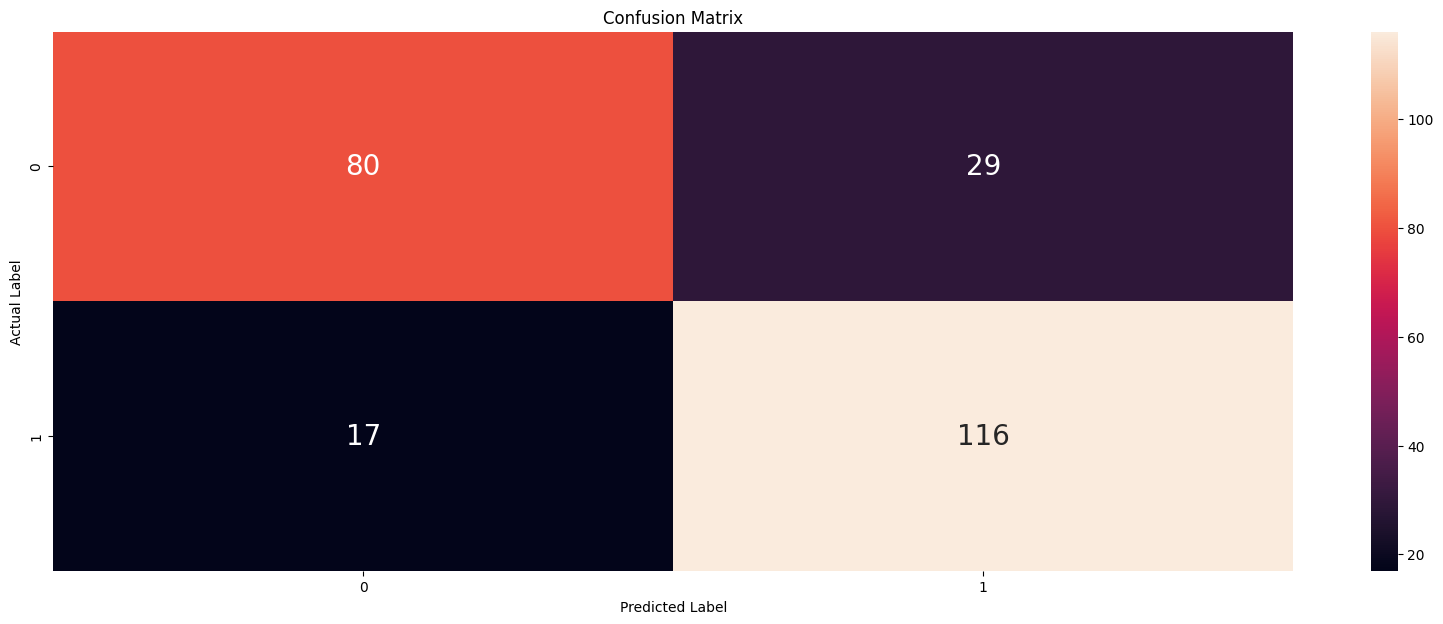


The Area Under the Receiver Operating Characteristic Curve score is: 0.8


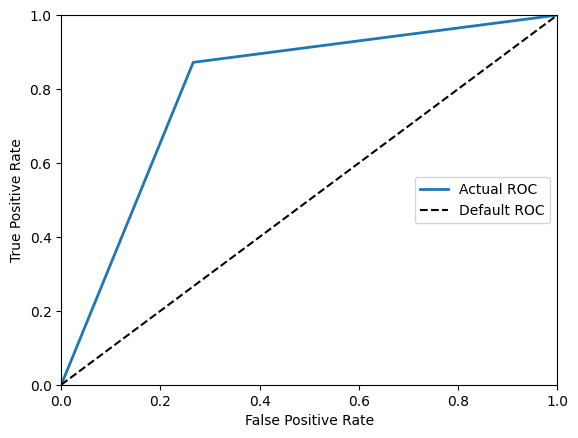

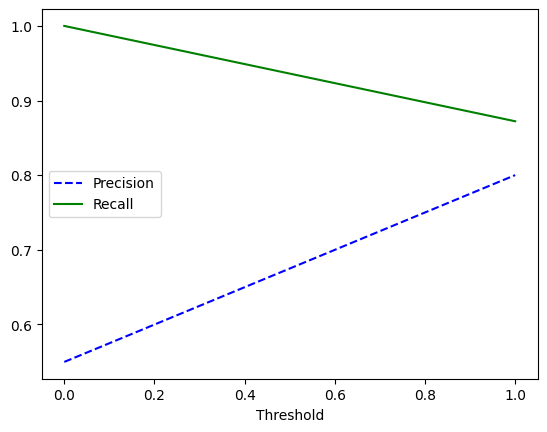

In [51]:
logistic_regression_model = LogisticRegression()

logistic_regression_y_train_predictions = cross_val_predict(logistic_regression_model, x_train, y_train, cv=10)

evaluate_model_performance(y_train, logistic_regression_y_train_predictions, "Logistic Regression")

Given the evaluations above, the accuracy score of 81 sounds good! However for classification, this may not be the best measure of model's success. An accuracy score is calculated by dividing the number of correct predictions by the total number of predictions. Based on the confusion matrix, our model correctly predicted 196 of 242 occurrences. However, given our data is focused on predicting whether a patient will get a heart attack, we cannot afford to have a large number of false negatives (telling patients they won't get a heart attack but they end up getting one). 

Therefore the confusion matrix is a better measure of whether this model is successful or not. Our main focus should be having a high recall of predicting whether a patient will get a heart attack. What this means is that we correctly predicted a patient will get a heart attack most of the time along with a few false positive diagnoses. Based on the report above, this recall is 87% which is very high. We misdiagnosed 17 patients telling them they will not have a heart attack but did, however we correctly diagnosed 116 patients along with 29 false positives. 

Based on the high recall for positive cases, decent accuracy, and decent AUC ROC score I will say this model did a pretty good job.

### Evaluating on test data with standard training

---------------------------------------------------
Evaluation Results of the Logistic Regression model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.89      0.86      0.88        29
    Positive       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



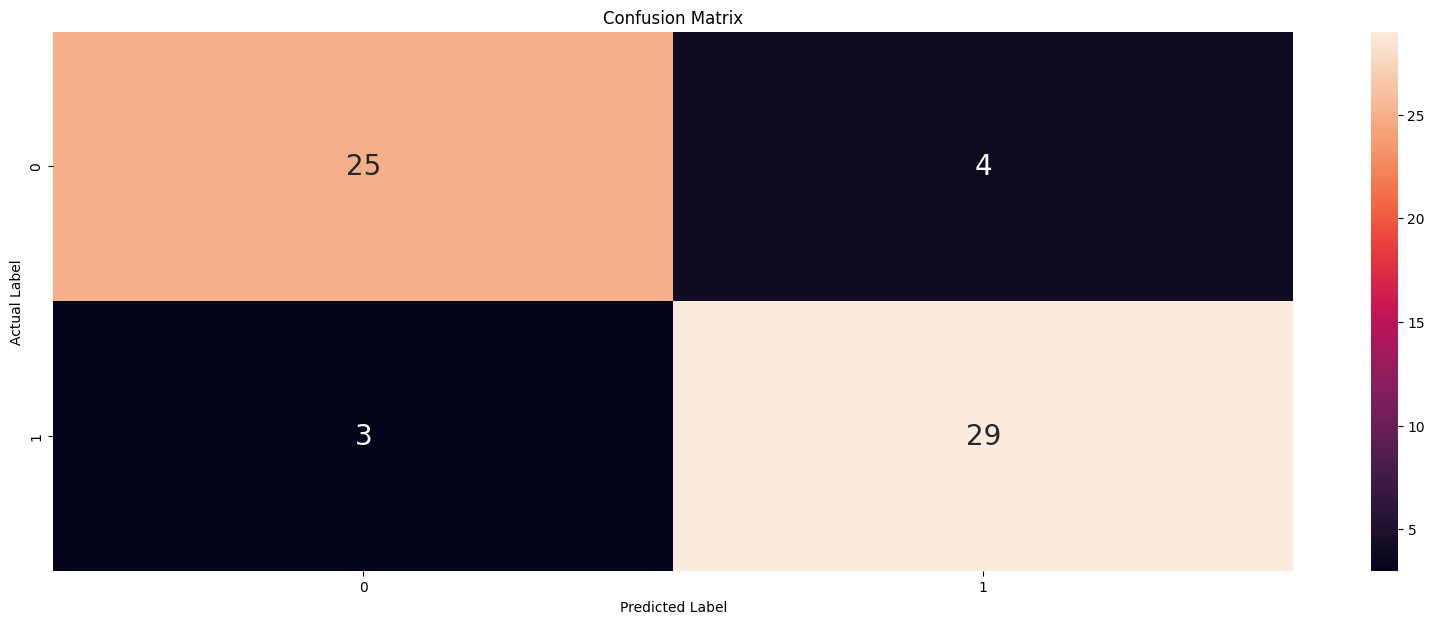


The Area Under the Receiver Operating Characteristic Curve score is: 0.88


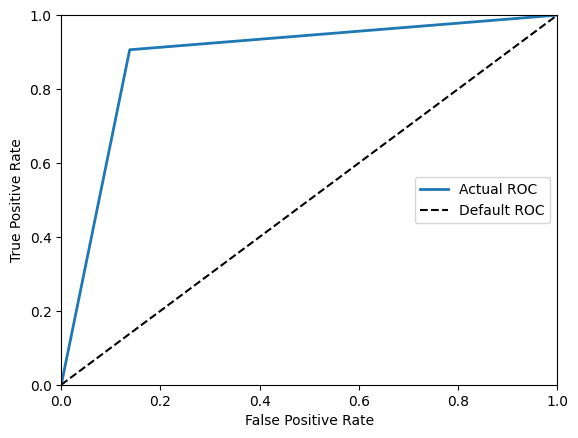

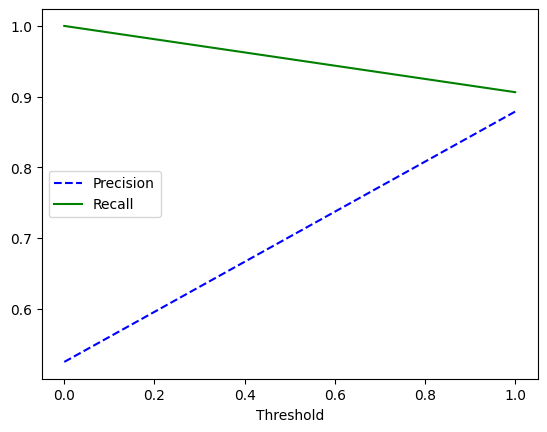

In [52]:
logistic_regression_model.fit(x_train, y_train)

logistic_regression_y_test_predictions = logistic_regression_model.predict(x_test)

evaluate_model_performance(y_test, logistic_regression_y_test_predictions, "Logistic Regression")

Given the evaluations above, the accuracy score of 89 is even better than the training evaluation! Continuing on from the training evaluation, the test data's positive recall is very high at 91%! What this means is that we correctly diagnosed 29 patients that they will get a heart attack, we misdiagnosed 3 patients saying they will not get a heart attack, along with 4 false positives. This is incredible since model's tend to not generalize very well to unseen data however this logistic regression model did the exact opposite!

### Feature Importance Plot

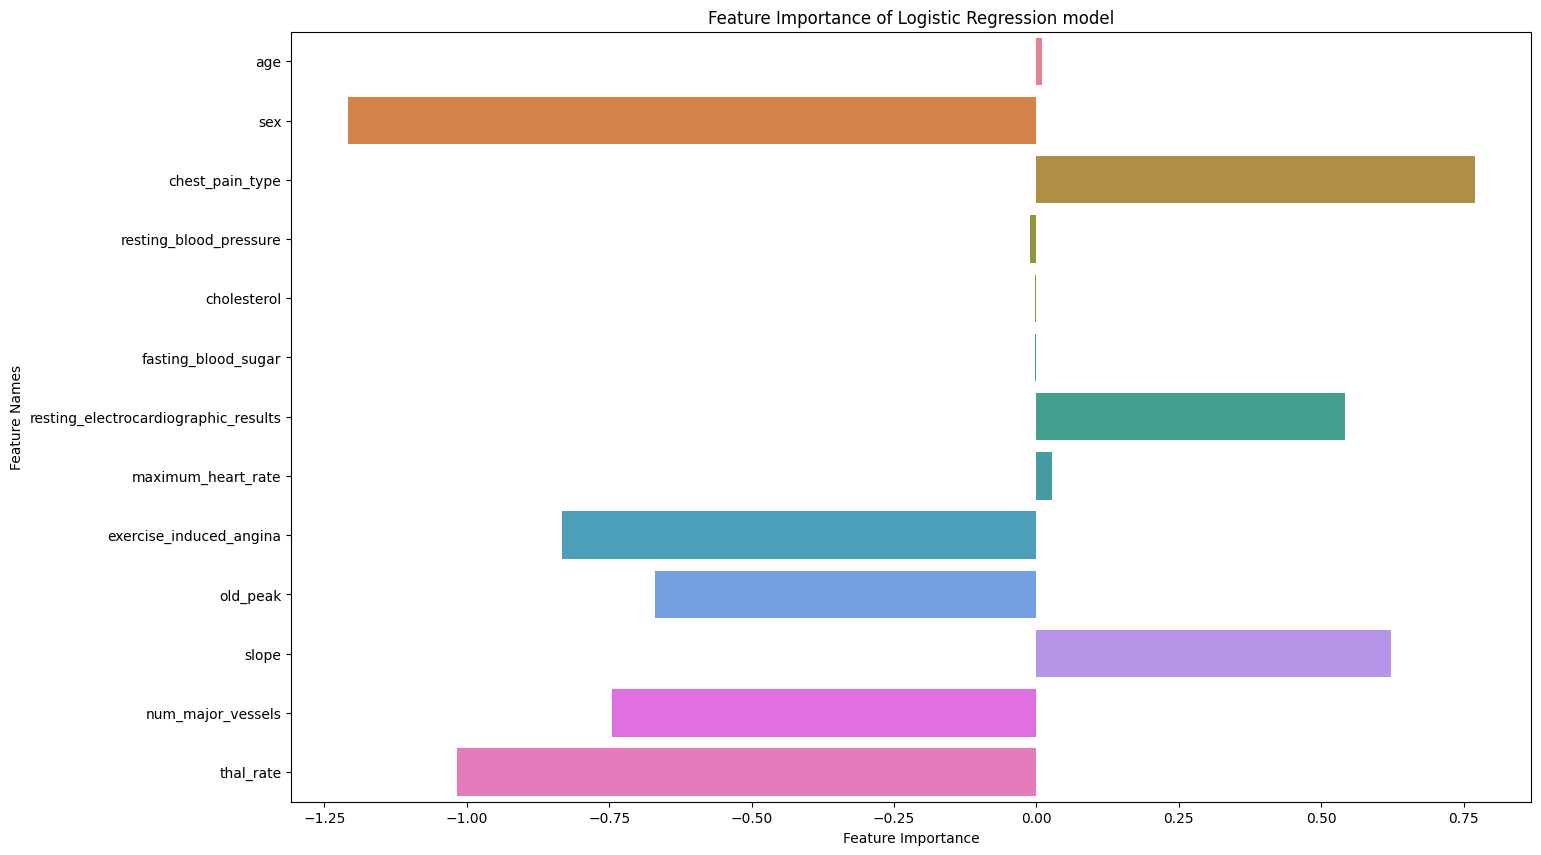

In [53]:
plot_feature_importance(logistic_regression_model, "Logistic Regression", x_train.columns)

It is very interesting that the only features that are truly considered is the chest pain type, the resting electrocardiographic results, and the slope. What is also very interesting is that there is the presence of negative feature importances which indicates that the model is either underfitting the data or this feature does not help the model in making predictions. A negative feature importance also means that this feature causes the model to perform worse than normal.

**I am sure the cause of this is the limited number of training values since the entire dataset does not exceed 1000 records.**

## 8b. Support Vector Machines (SVMs) 

### Evaluating on training data with cross validation training

---------------------------------------------------
Evaluation Results of the Support Vector Machines (SVMs) model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.84      0.75      0.79       109
    Positive       0.81      0.88      0.84       133

    accuracy                           0.82       242
   macro avg       0.82      0.82      0.82       242
weighted avg       0.82      0.82      0.82       242



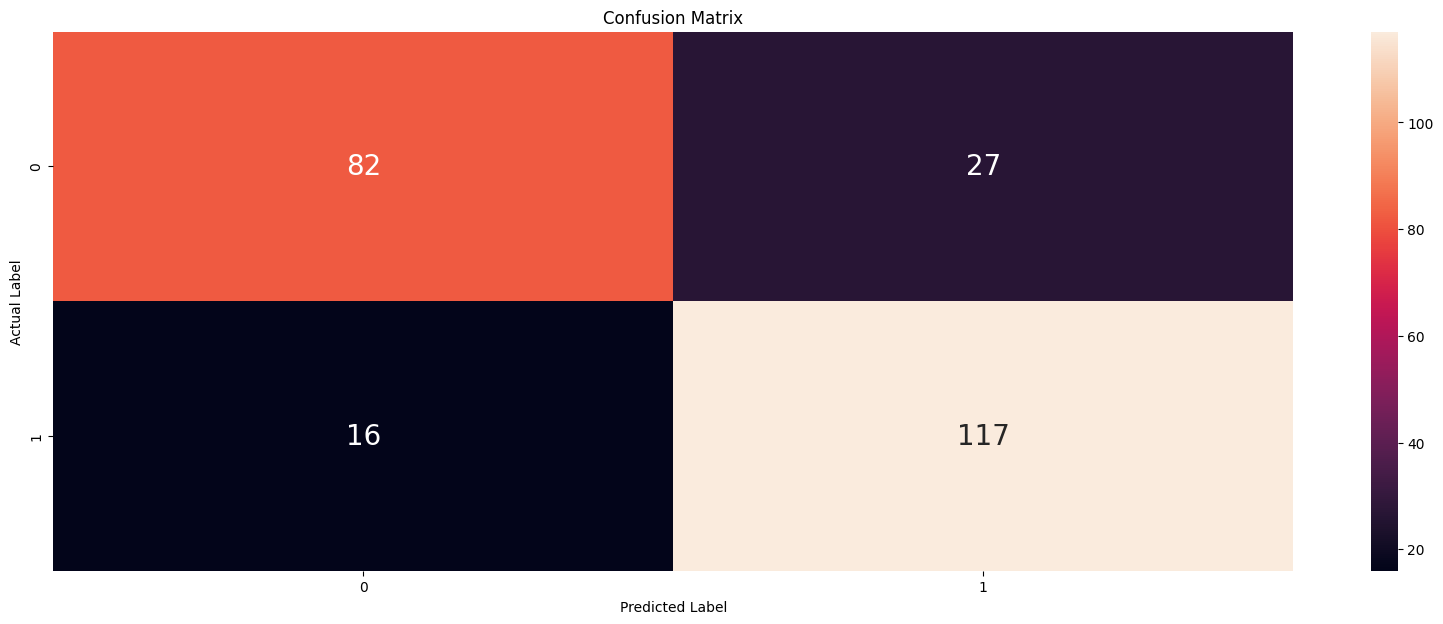


The Area Under the Receiver Operating Characteristic Curve score is: 0.82


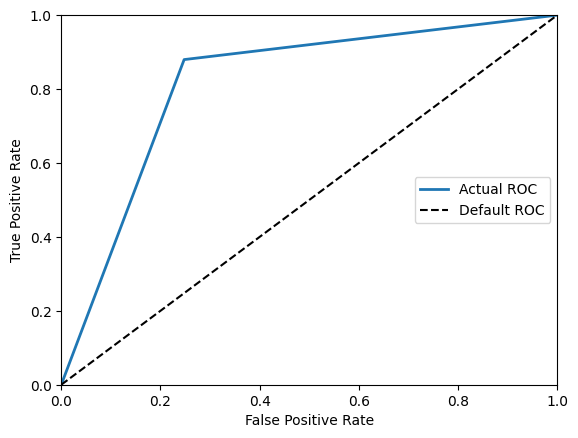

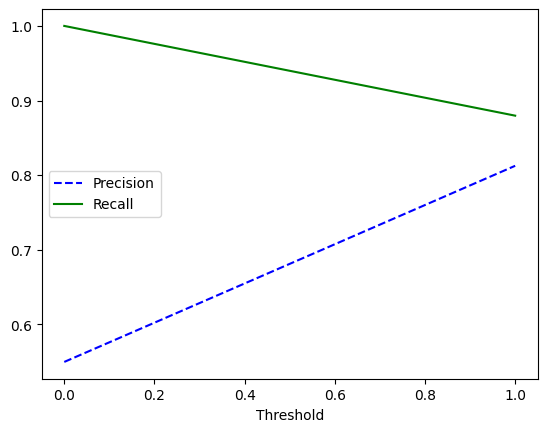

In [54]:
svm_model = SVC(kernel='linear')

svm_y_train_predictions = cross_val_predict(svm_model, x_train, y_train, cv=10)

evaluate_model_performance(y_train, svm_y_train_predictions, "Support Vector Machines (SVMs)")

The accuracy for this SVM model is slightly better than the logistic regression one with a value of 82% compared to 81%. The recall for the positive cases is also slightly better at 88% compared to 87%. All in all, this model's performance was very slightly better than the logistic regression results above.

### Evaluating on test data with standard training

---------------------------------------------------
Evaluation Results of the Support Vector Machines (SVMs) model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86        29
    Positive       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



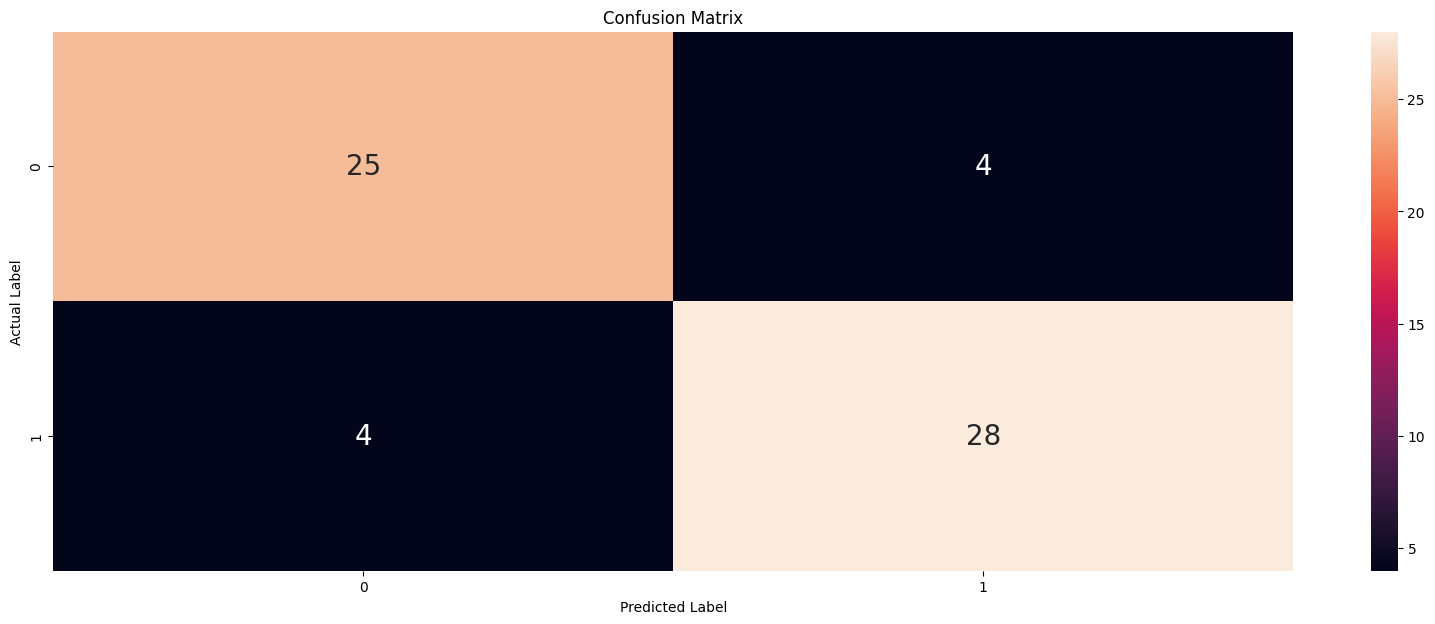


The Area Under the Receiver Operating Characteristic Curve score is: 0.87


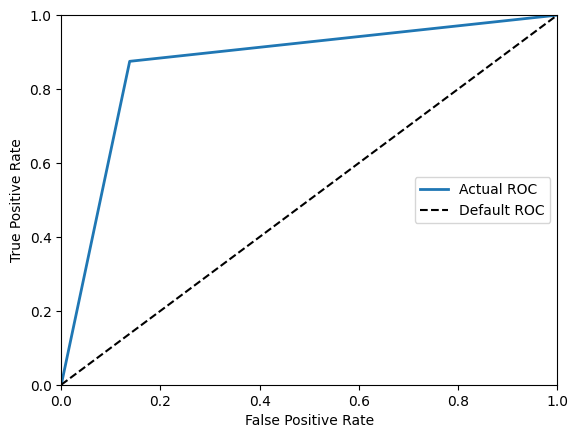

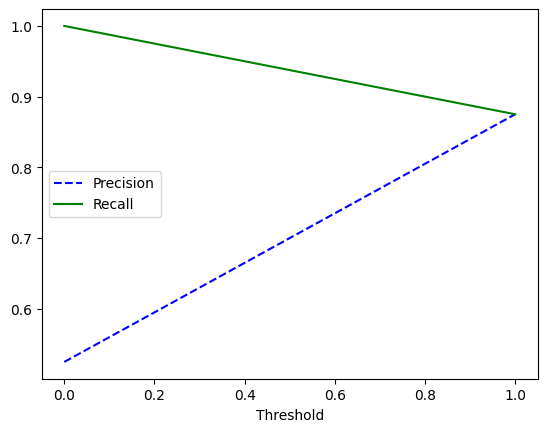

In [55]:
svm_model.fit(x_train, y_train)

svm_y_test_predictions = svm_model.predict(x_test)

evaluate_model_performance(y_test, svm_y_test_predictions, "Support Vector Machines (SVMs)")

The performance of the SVM model on unforseen data isn't as good as the logistic regression model above as indicated by the accuracy score, the positive cases' recall score, and the AUC ROC score being slightly worse than the logistic regression ones. 

### Feature Importance Plot

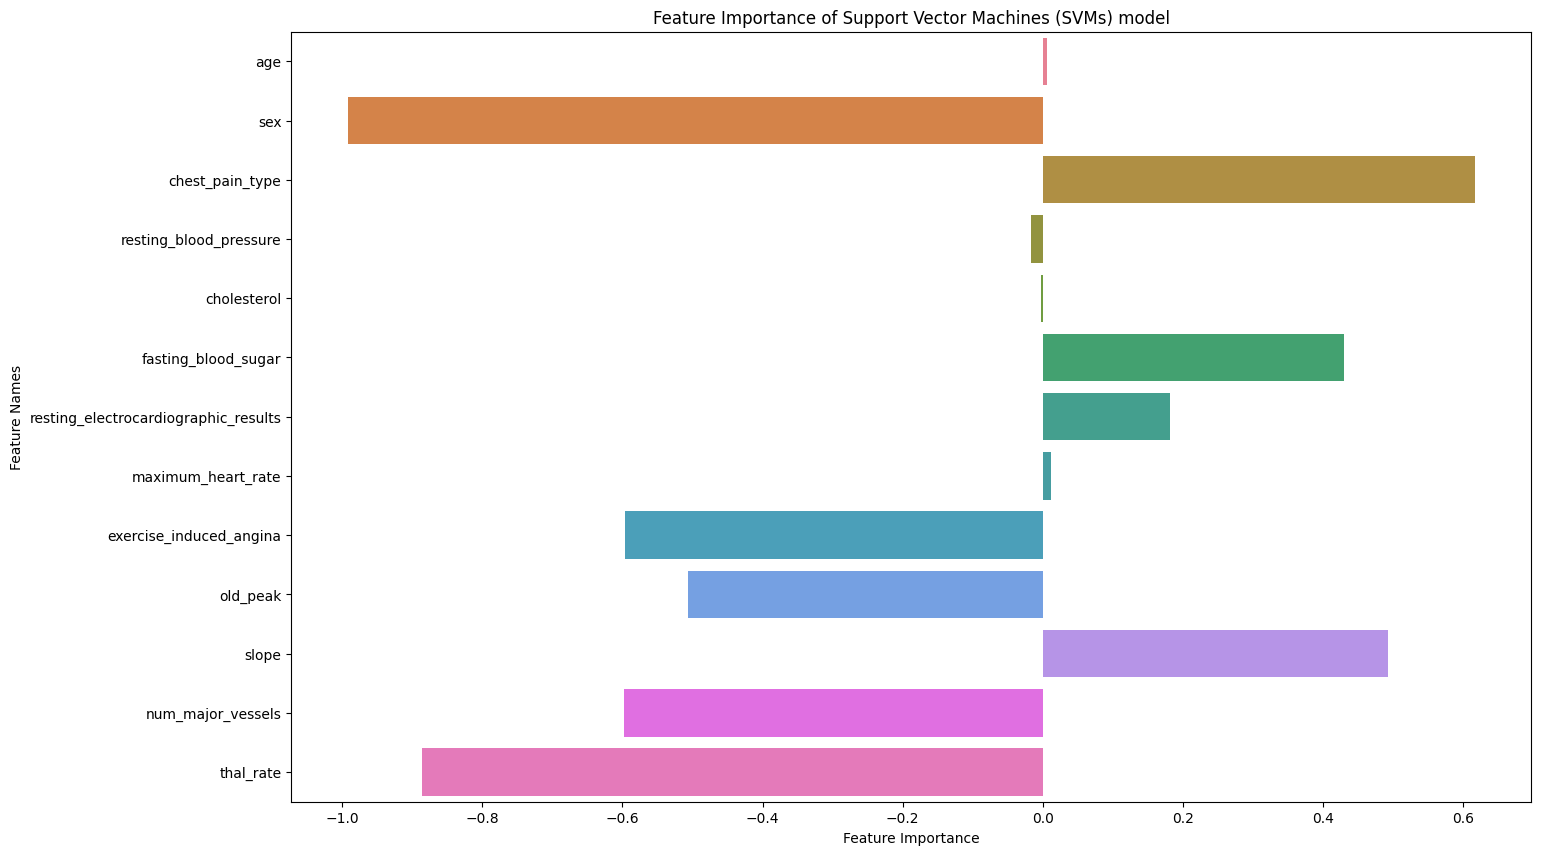

In [56]:
plot_feature_importance(svm_model, "Support Vector Machines (SVMs)", x_train.columns)

Compared to the logistic regression feature importance, this one is very similiar however it actually values fasting blood sugar. Logistic Regression did not consider this feature however SVM does. Also notably the resting_electrocardiographic_results have a lower importance than they did for logistic regression.

## 8c. Naive Bayes 

### Evaluating on training data with cross validation training

---------------------------------------------------
Evaluation Results of the Naive Bayes model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.78      0.75      0.77       109
    Positive       0.80      0.83      0.81       133

    accuracy                           0.79       242
   macro avg       0.79      0.79      0.79       242
weighted avg       0.79      0.79      0.79       242



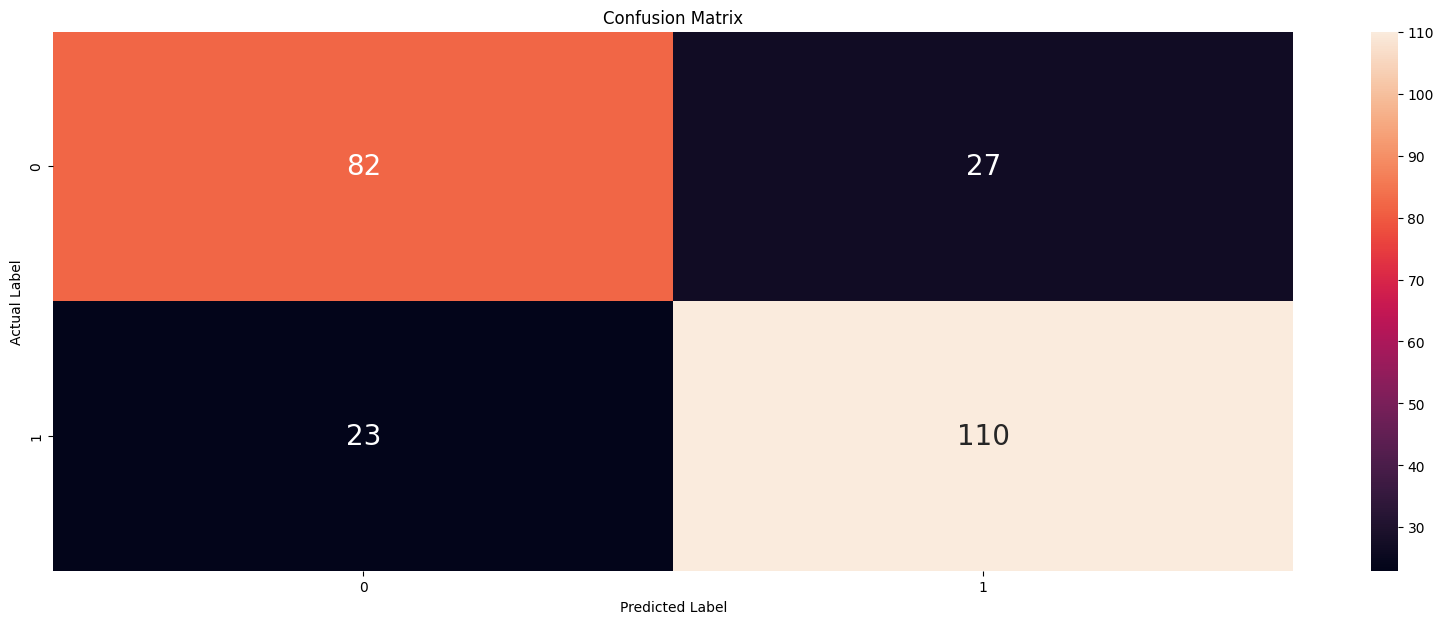


The Area Under the Receiver Operating Characteristic Curve score is: 0.79


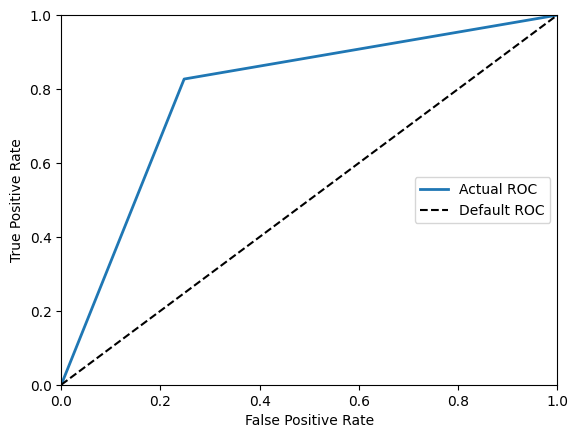

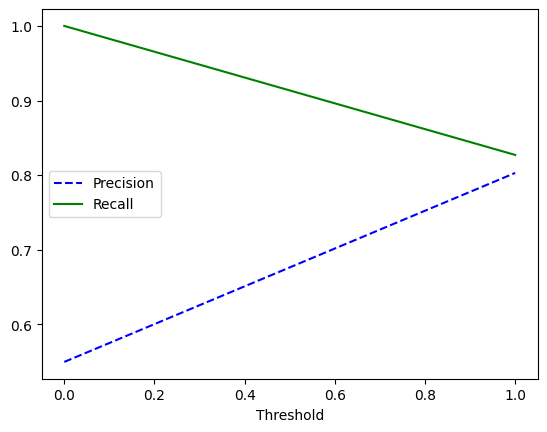

In [57]:
naive_bayes_model = GaussianNB()

naive_bayes_y_train_predictions = cross_val_predict(naive_bayes_model, x_train, y_train, cv=10)

evaluate_model_performance(y_train, naive_bayes_y_train_predictions, "Naive Bayes")

The Naive Bayes model performs worse than the Logistic Regression and SVM models in accuracy, positive cases' recall score, and ROC AUC score making it not the ideal model for this problem.

### Evaluating on test data with standard training

---------------------------------------------------
Evaluation Results of the Naive Bayes model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87        29
    Positive       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



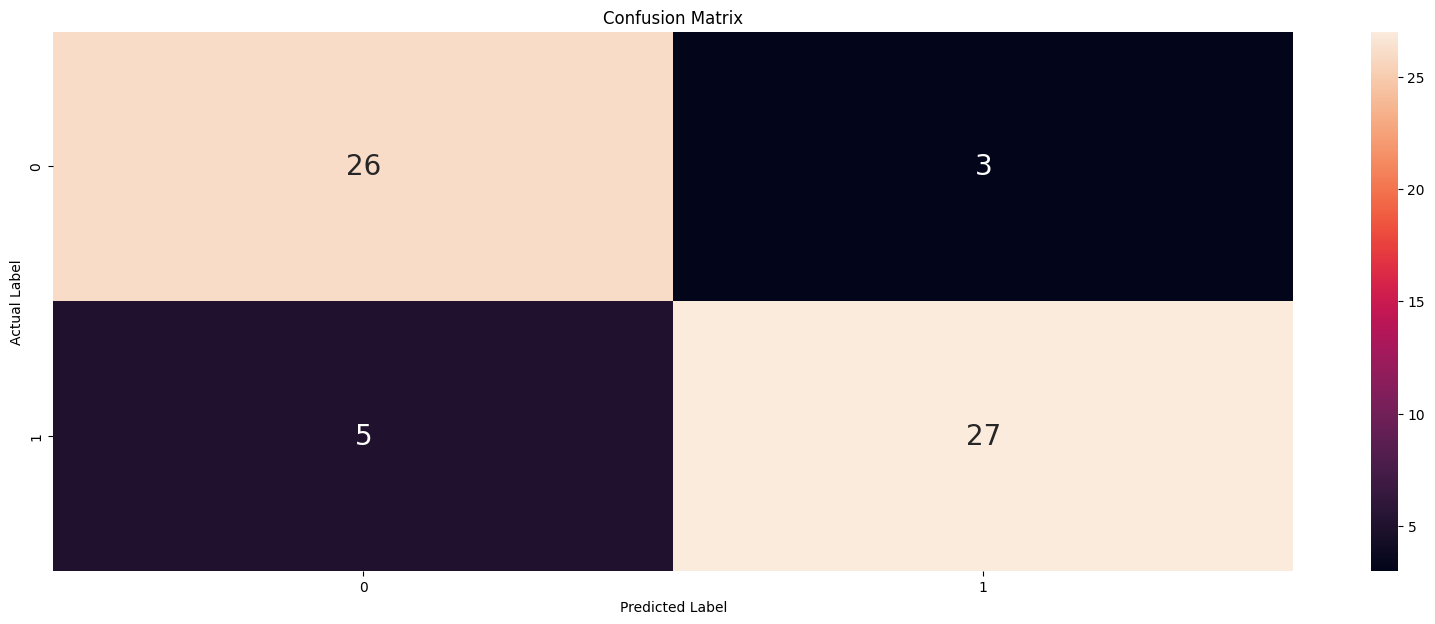


The Area Under the Receiver Operating Characteristic Curve score is: 0.87


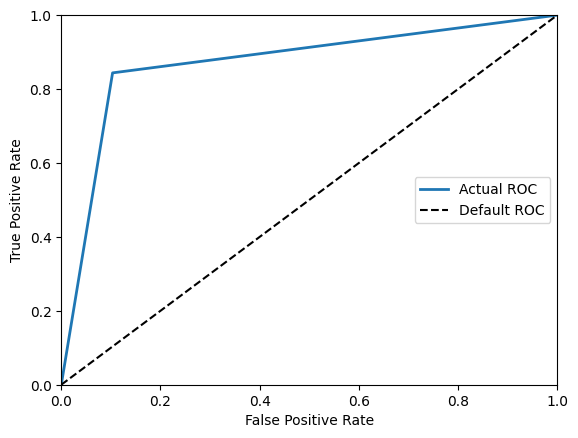

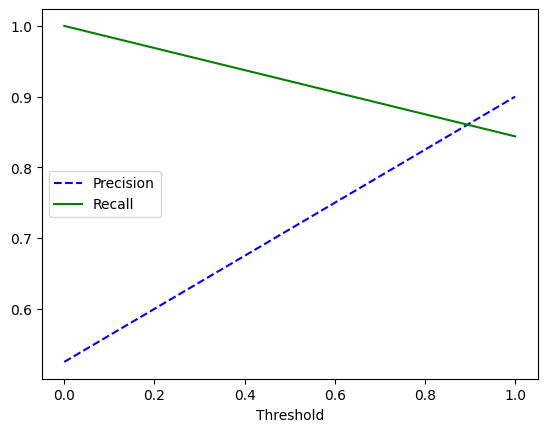

In [58]:
naive_bayes_model.fit(x_train, y_train)

naive_bayes_y_test_predictions = naive_bayes_model.predict(x_test)

evaluate_model_performance(y_test, naive_bayes_y_test_predictions, "Naive Bayes")

For its performance on unforseen data, it does a lot better except for the positive cases' recall score which is significantly lower than the logistic regression and SVM model scores.

### Feature Importance Plot

Cannot generate a feature importance plot for Naive Bayes since there doesn't seem to be an easy way to do this for Gaussian Naive Bayes models. 

## 8d. Decision Tree

### Evaluating on training data with cross validation training

---------------------------------------------------
Evaluation Results of the Decision Tree model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.71      0.68      0.69       109
    Positive       0.75      0.77      0.76       133

    accuracy                           0.73       242
   macro avg       0.73      0.73      0.73       242
weighted avg       0.73      0.73      0.73       242



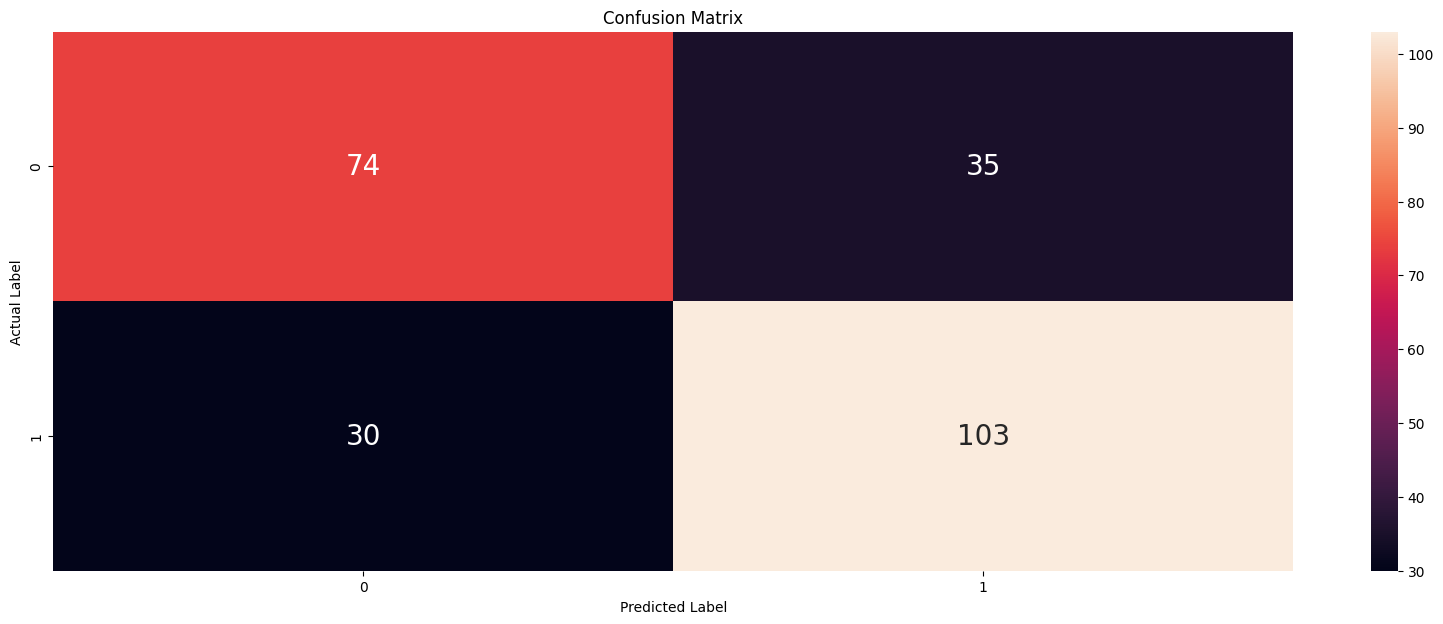


The Area Under the Receiver Operating Characteristic Curve score is: 0.73


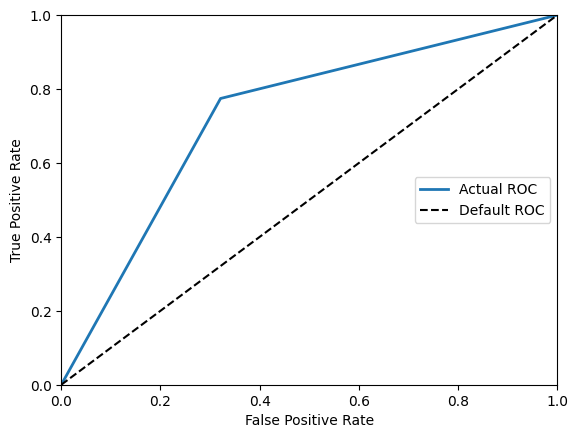

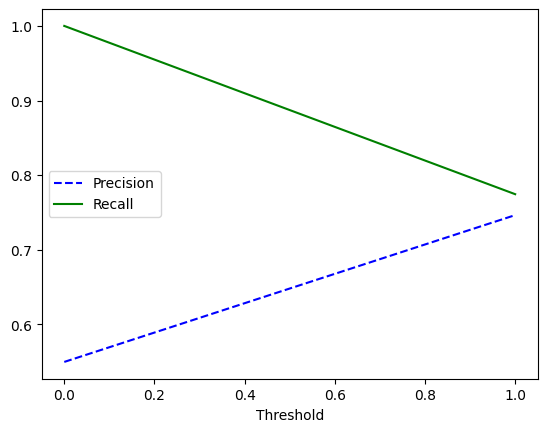

In [59]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy")

decision_tree_y_train_predictions = cross_val_predict(decision_tree_model, x_train, y_train, cv=10)

evaluate_model_performance(y_train, decision_tree_y_train_predictions, "Decision Tree")

This model performs significantly worse than the previous models based on all metrics such as accuracy, recall score, and ROC AUC score.

### Evaluating on test data with standard training

---------------------------------------------------
Evaluation Results of the Decision Tree model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.77      0.93      0.84        29
    Positive       0.92      0.75      0.83        32

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61



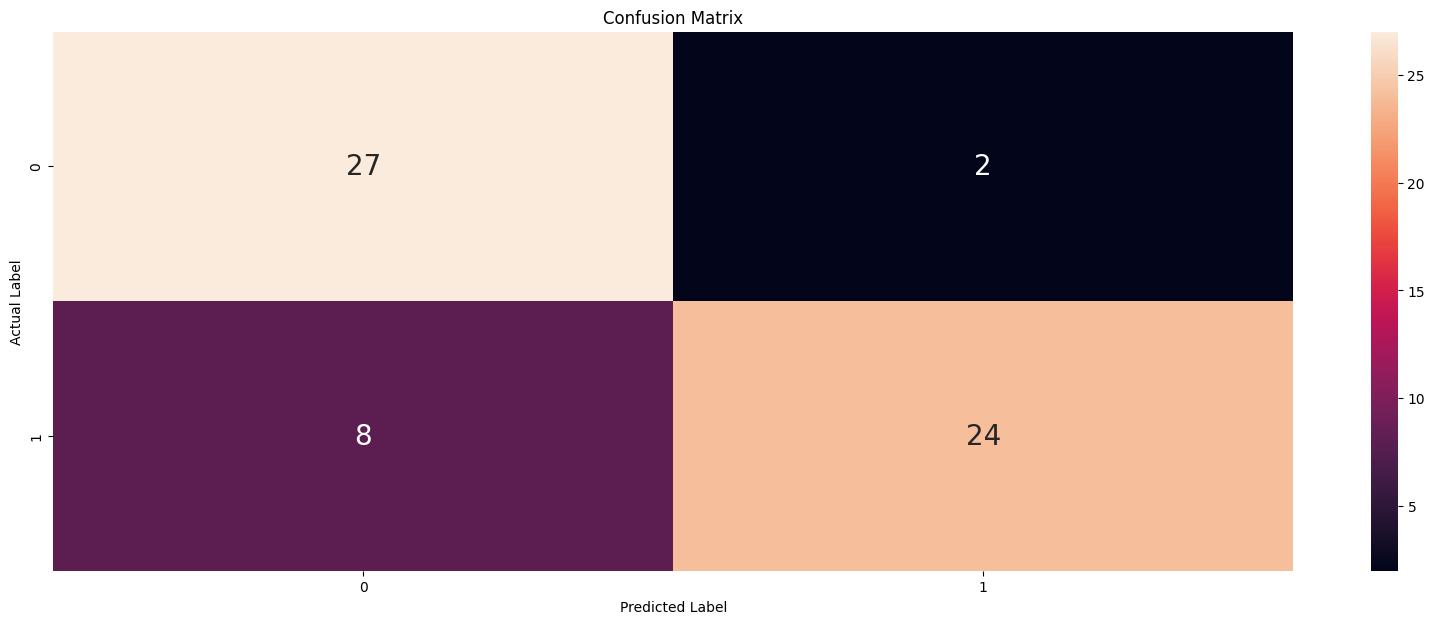


The Area Under the Receiver Operating Characteristic Curve score is: 0.84


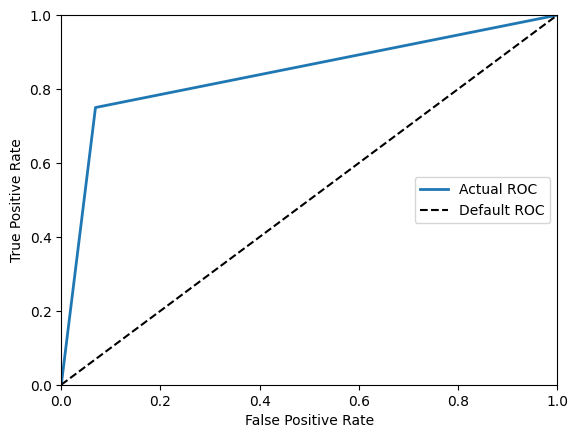

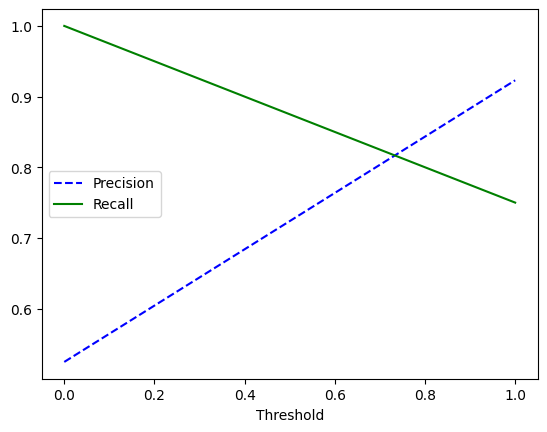

In [60]:
decision_tree_model.fit(x_train, y_train)

decision_tree_y_test_predictions = decision_tree_model.predict(x_test)

evaluate_model_performance(y_test, decision_tree_y_test_predictions, "Decision Tree")

This model performs significantly worse on unforseen data as well compared to the previous models.

### Feature Importance Plot

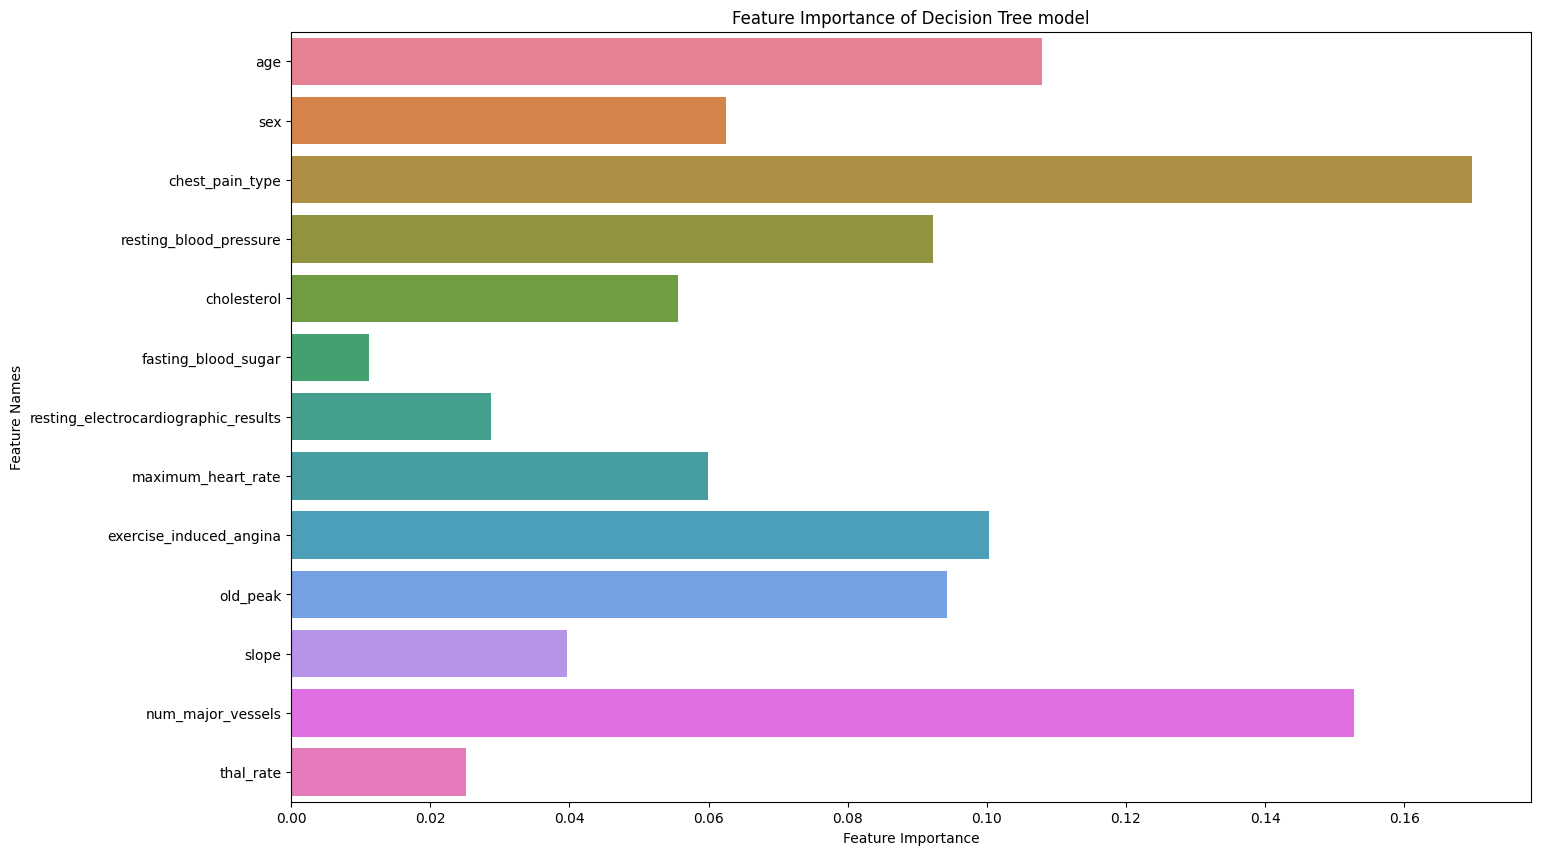

In [61]:
plot_feature_importance(decision_tree_model, "Decision Tree", x_train.columns)

This feature importance graph proves that this Decision Tree model focuses on completely different features than the Logistic Regression and the SVM models. The key attributes that it has in common with the other models is chest pain type only. The other attributes such as age, resting blood pressure, exercise induced angina, and number of major vessels were not important to Logistic Regression and SVM.

## 8e. Random Forest

### Evaluating on training data with cross validation training

---------------------------------------------------
Evaluation Results of the Random Forest model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79       109
    Positive       0.82      0.84      0.83       133

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



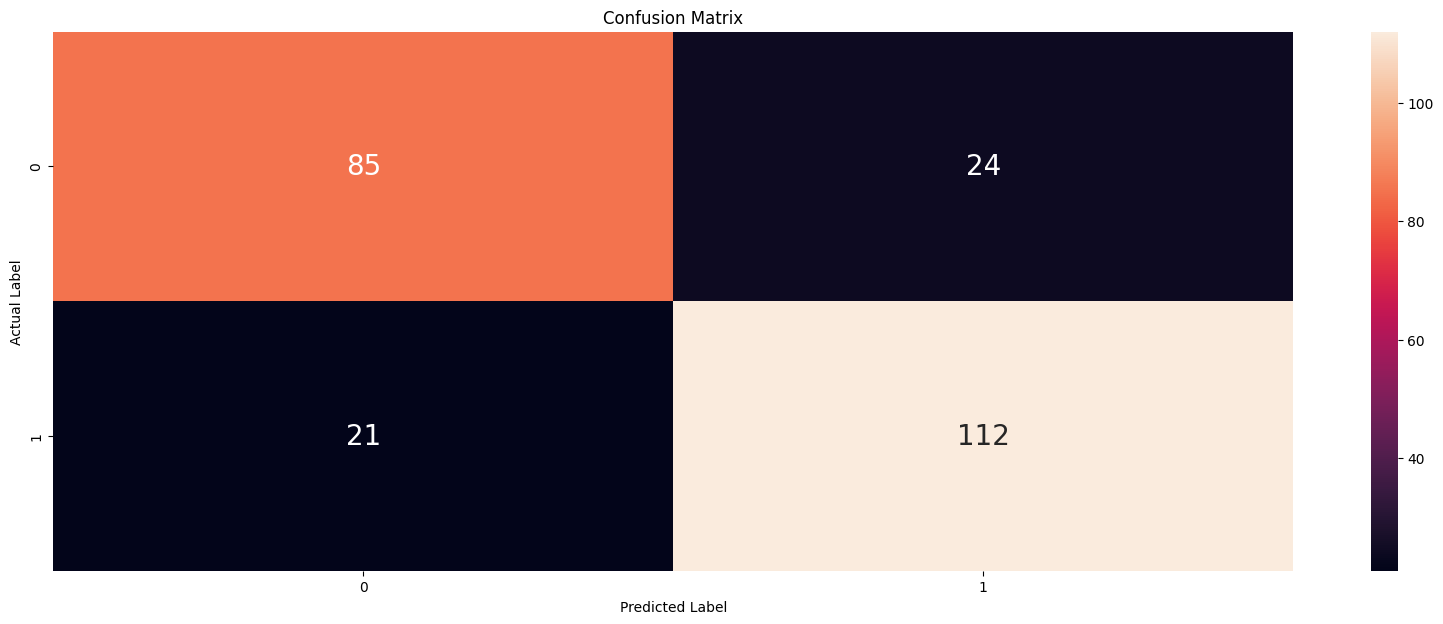


The Area Under the Receiver Operating Characteristic Curve score is: 0.81


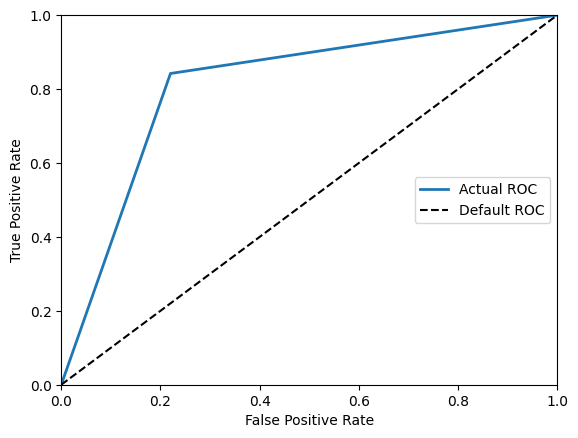

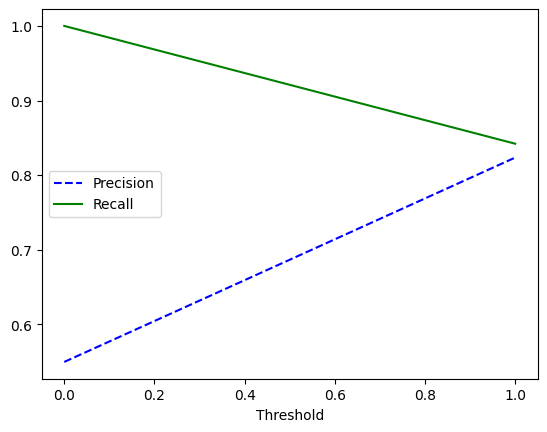

In [62]:
random_forest_model = RandomForestClassifier(n_estimators=200,criterion="entropy")

random_forest_y_train_predictions = cross_val_predict(random_forest_model, x_train, y_train, cv=10)

evaluate_model_performance(y_train, random_forest_y_train_predictions, "Random Forest")

This random forest model performs a lot better than the Decision Tree model but the recall score for the positive cases is slightly worse than the Logistic Regression and SVM models.

### Evaluating on test data with standard training

---------------------------------------------------
Evaluation Results of the Random Forest model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83        29
    Positive       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



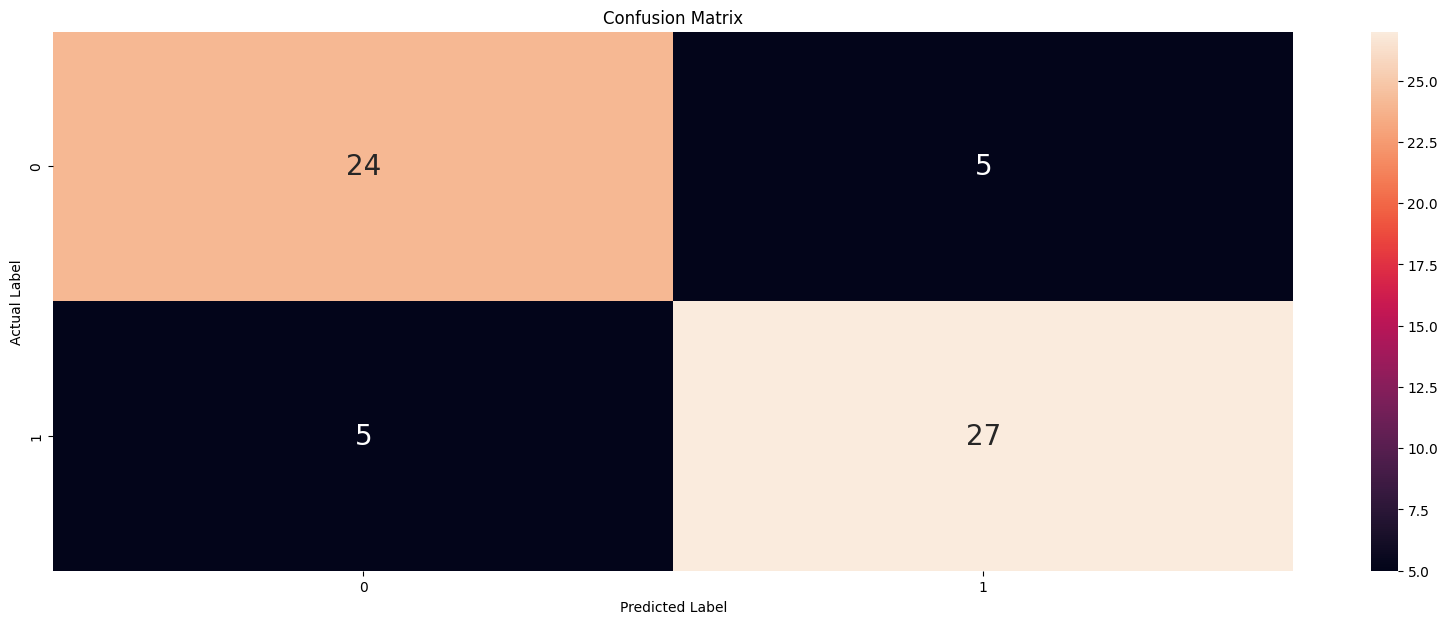


The Area Under the Receiver Operating Characteristic Curve score is: 0.84


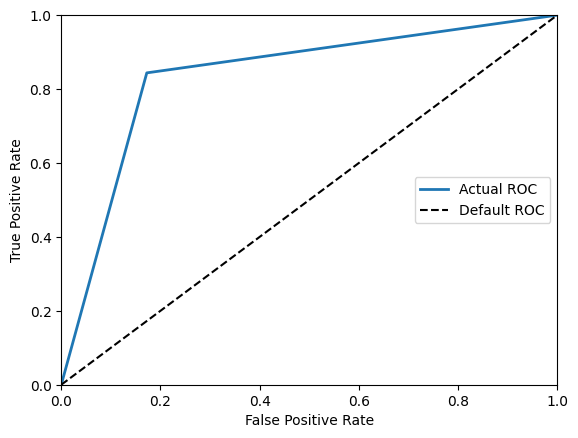

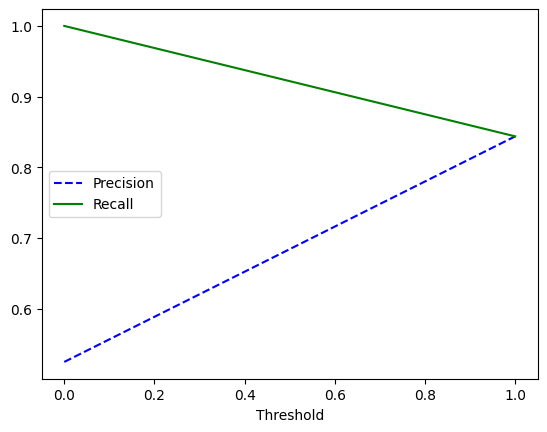

In [63]:
random_forest_model.fit(x_train, y_train)

random_forest_y_test_predictions = random_forest_model.predict(x_test)

evaluate_model_performance(y_test, random_forest_y_test_predictions, "Random Forest")

This random forest model performs a lot better than the Decision Tree model but the accuracy score is slightly lower than the Logistic Regression model. This is a very good model along with the Logistic Regression and SVM model.

### Feature Importance Plot

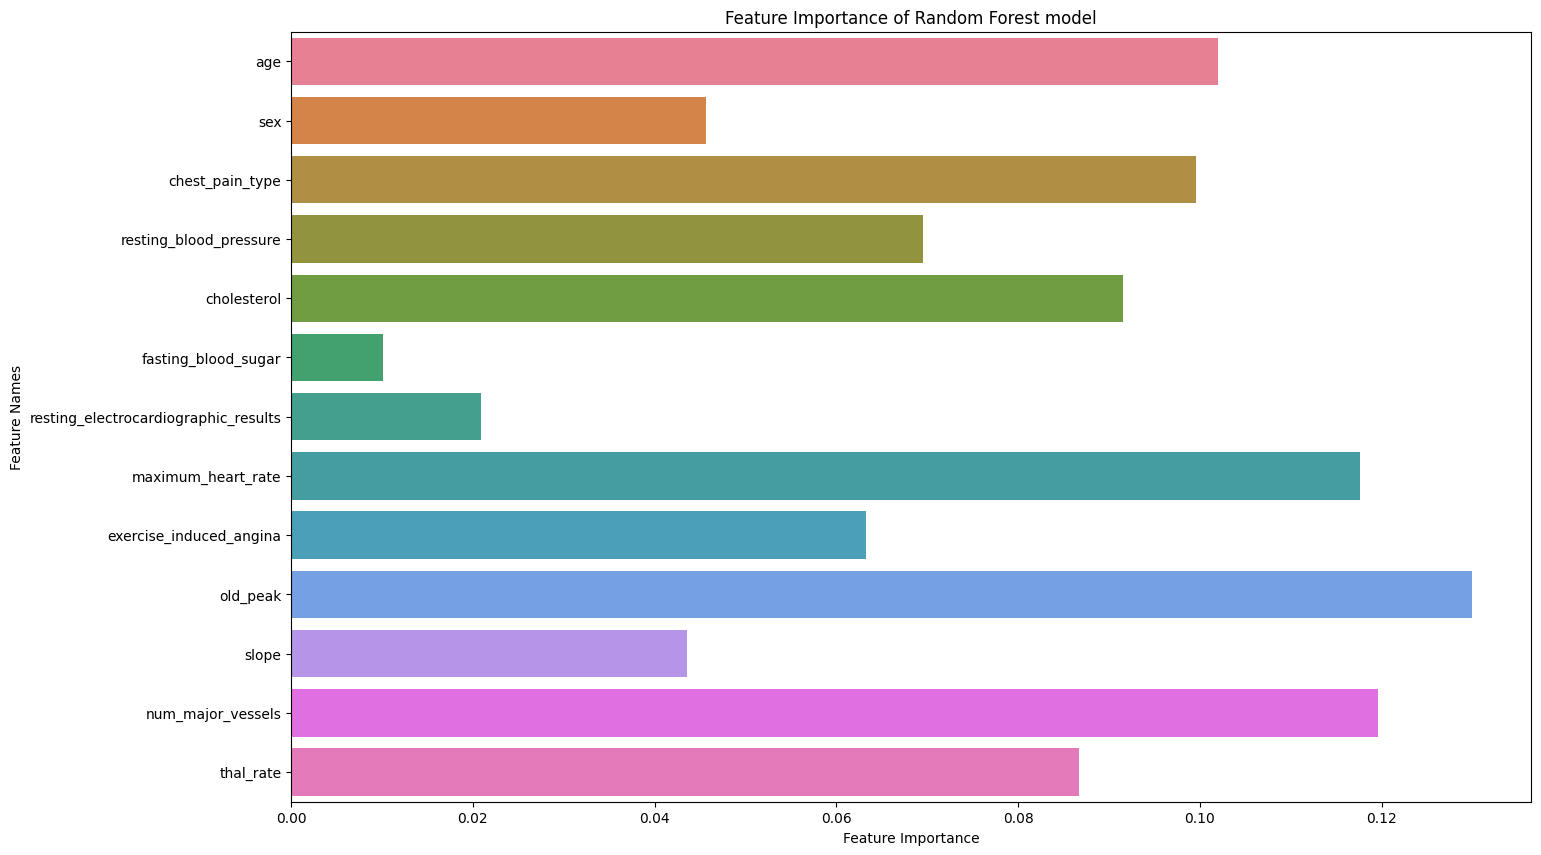

In [64]:
plot_feature_importance(random_forest_model, "Random Forest", x_train.columns)

This feature important plot is similiar to the Decision Tree one in which it factors in a lot more features as oppose to the Logistic Regression and SVM models. The unique attributes this model factors in compares to the other models is maximum_heart_rate and old_peak which is pretty interesting. It has age, chest pain type, and number of major vessels similiar to the Decision Tree model.

## 8f. K-Nearest Neighbors

### Evaluating on training data with cross validation training

---------------------------------------------------
Evaluation Results of the K-Nearest Neighbor model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.62      0.55      0.59       109
    Positive       0.66      0.73      0.70       133

    accuracy                           0.65       242
   macro avg       0.64      0.64      0.64       242
weighted avg       0.65      0.65      0.65       242



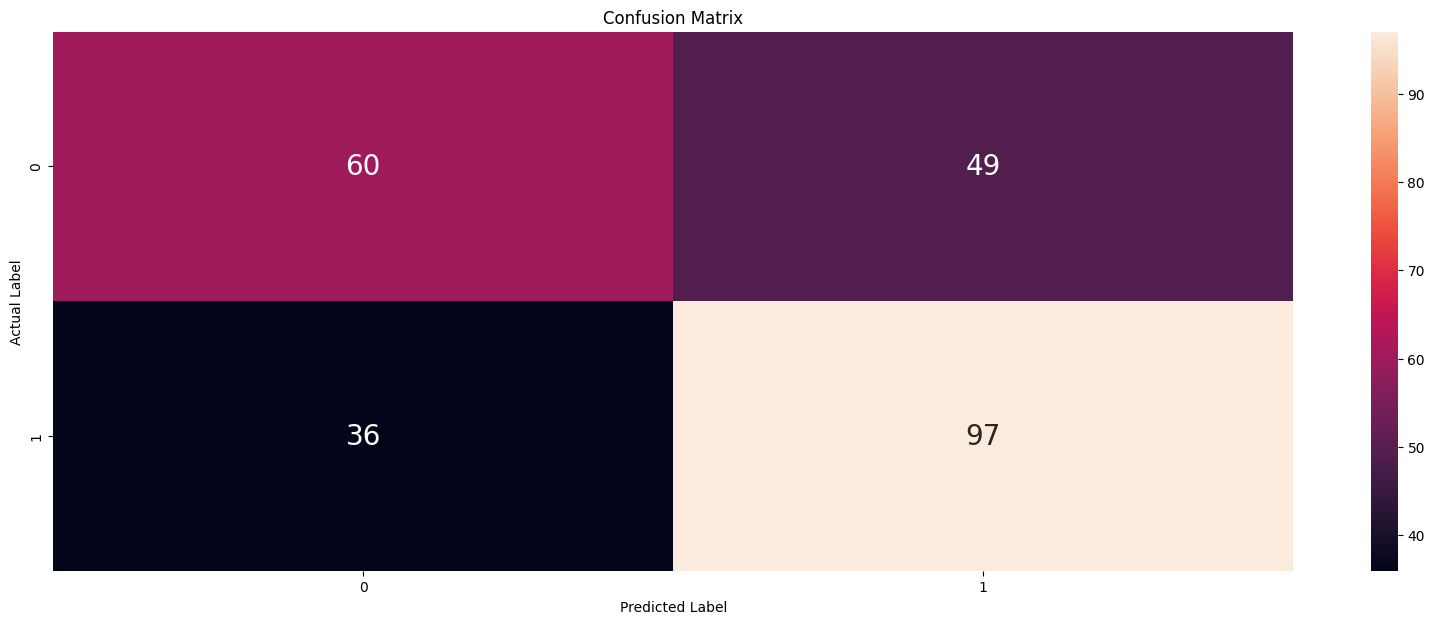


The Area Under the Receiver Operating Characteristic Curve score is: 0.64


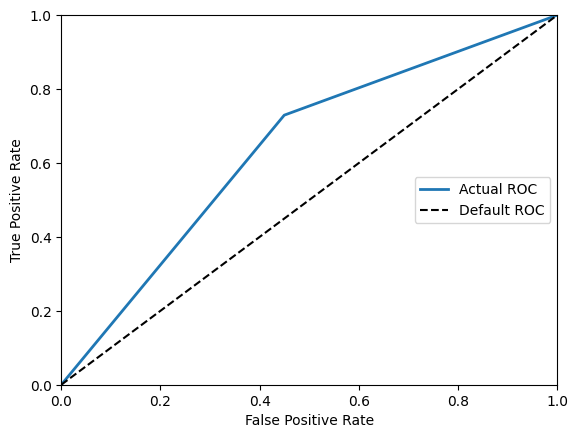

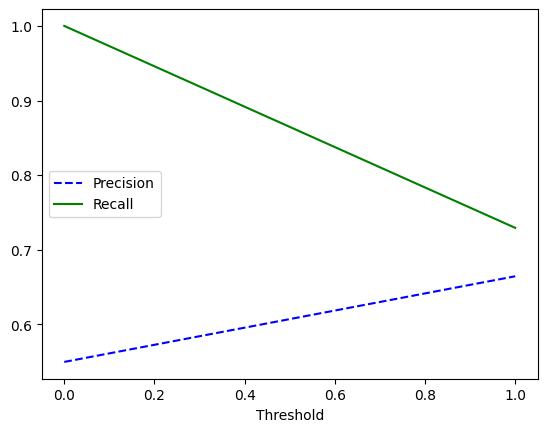

In [65]:
# Calculating number of k centers by finding the square root of the total number of records in the data
n_samples = int(math.sqrt(len(df_heart_data)))
k_nearest_neighbor_model = KNeighborsClassifier(n_samples)

k_nearest_neighbor_y_train_predictions = cross_val_predict(k_nearest_neighbor_model, x_train, y_train, cv=10)

evaluate_model_performance(y_train, k_nearest_neighbor_y_train_predictions, "K-Nearest Neighbor")

This model performs the poorest of all the existing models so far across all metrics.

### Evaluating on test data with standard training

---------------------------------------------------
Evaluation Results of the K-Nearest Neighbor model
---------------------------------------------------

The classification report with the individual precision, recall, accuracy, and f1-scores can be seen below.

              precision    recall  f1-score   support

    Negative       0.68      0.66      0.67        29
    Positive       0.70      0.72      0.71        32

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61



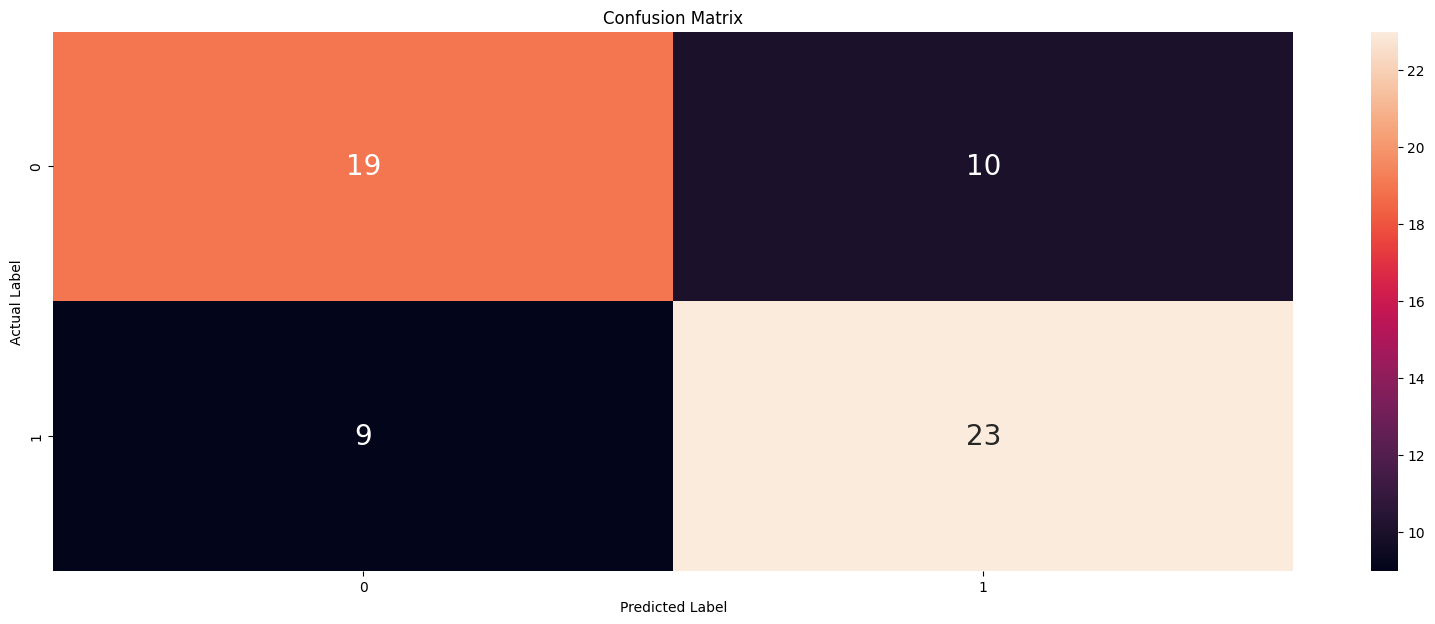


The Area Under the Receiver Operating Characteristic Curve score is: 0.69


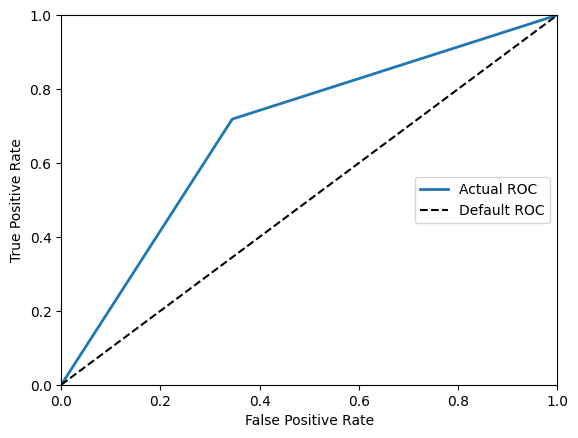

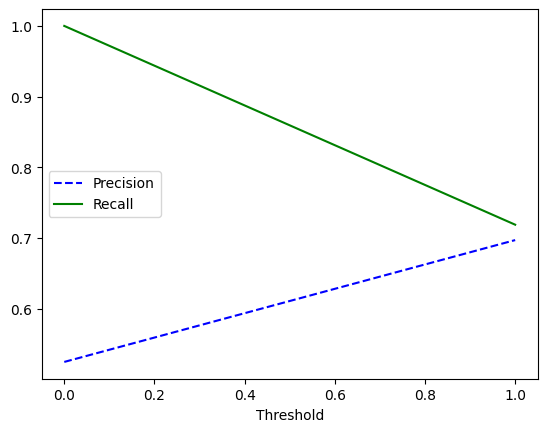

In [66]:
k_nearest_neighbor_model.fit(x_train, y_train)

k_nearest_neighbor_y_test_predictions = k_nearest_neighbor_model.predict(x_test)

evaluate_model_performance(y_test, k_nearest_neighbor_y_test_predictions, "K-Nearest Neighbor")

It's performance on unforeseen data is just as bad making it not a good model in this circumstance.

### Feature Importance Plot

Unfortunately, K-Nearest Neighbor does not provide a way of showing the importance of each feature. 
The only way to get a feature importance list is to use a Random Forest model as shown above.

# 8. Model Observations

The three best performing models are **Logistic Regression, SVM, and RandomForestRegressor**. All of these models were not tuned so these results do not indicate that the other models cannot be used for the data. All it means is that with no model tuning, these models performed the best based on prediction accuracy, recall score, and Area under the ROC curve.  

Recall score was the most important metric for our dataset since it measures the number of true positives found out of all actual positive cases. For our data, detecting whether someone will get a heart attack is the highest priority so having a high recall score (correctly predicting most of the patients that will get a heart attack) is more important even if we have quite a few false positives. All 3 of these models had a pretty high recall score making them the ideal candidates to be further tuned, in order to achieve a higher recall score.

Before the actual model predictions, there were some key observations made about the data. One key observation was that majority of the patients had a moderate to high risk cholesterol level. What I mean by this is if all patients have a troublesome cholesterol level, which was the case, then it will not have an impact on determining whether a patient will get a heart attack or not since negative heart attack results also had troublesome cholesterol levels in the data. This hypothesis was proven right since none of the 3 best models relied on cholesterol level for generating predictions.

Another observation made was that there was a good variance in the data's resting blood pressure levels. I believed that this variance will make it a useful feature for predicting whether a person got a heart attack or not but this was proven false by all 3 best performing models. 

In addition to this, maximum heart rate did not seem to have an impact on any models except for RandomForestRegressor where it was one of the most important features. I anticipated more of an impact from maximum heart rate but was proven wrong.

Another interesting observation is that age was one of the most important features for RandomForestRegressor model which makes sense given the graph shown in Section 5b. The data seems to indicate that all patients from age 54 and below have a higher chance of getting a heart attack while above this age there is more negative cases than positive ones. This is most likely an example that does not generalize well for other heart attack data making this an example of poor quality data.

The final major observation is that chest pain type was unanimously an important feature for all 3 models. This was apparent in section 5f. Since all chest pain types besides asymptomatic had a larger number of positive results than negative ones, this seemed to be a feature that will help to predict whether a person gets a heart attack or not. This hypothesis was confirmed by all 3 models relying on it for predictions.

# 8. Conclusion

After exploring this heart data, I have a deeper understanding of the factors that may contribute to a heart attack. This made me more aware of my own health and the importance of knowing metrics such as my cholesterol level, maximum heart rate, and resting blood pressure. Although none of these factors will 100% lead to a heart attack by themselves, it is important to monitor these metrics and to make steps in your life to ensure that none of these factors ever reach a point where they can become a problem. 